In [1]:
### 1. Import modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
### 2. User-defined - inputs:

### Objective Function:
obj_func = 'Rosenbrock' # 2-D;

### Data inputs:
n_test = 50

### Student-t parameter input:
df1 = 5 # Degree(s)-of-freedom (DF)

### Acquisition / Utility function - MLE/Type II:
util_gp = 'RegretMinimized' # Gaussian MLE
util_stp = 'tRegretMinimized' # Student-t MLE

#util_gp = 'ExpectedImprovement' # Gaussian MLE
#util_stp = 'tExpectedImprovement' # Student-t MLE

### Probabilistic / Surrogate / Stochastic model - MLE/Type II: 
#surrogate_model_gp = 'Gaussian Process'
surrogate_model_stp = 'Student-t Process'

### Covariance Function:
cov_func = squaredExponential()
#cov_func = matern32()
#cov_func = matern52()

n_init = 5  # Number of iterations used to initialise Bayesian optimisation; minimum 2

### MLE / Type II Empirical Bayes:
optimize = False # MLE Boolean
usegrads = False # MLE Boolean (pyGPGO not programmed for Student-t MLE)


In [3]:
### 3. Objective Function - Rosenbrock(x) 2-D:

if obj_func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
    max_iter = (10 * dim)*0 + 100  # iterations of Bayesian optimisation
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def f_syn_polarity(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)
      
    def f_syn_transform_polarity(x1_training, x2_training):
            return operator * (np.sqrt(2 * (y_global_orig - f_syn_polarity(x1_training, x2_training))))
            

In [4]:
### 4a. Add new acquisition functions: add CBM & ERM (Nyugen and Osborne, 2019) method .

### Inherits from class Acquisition()

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        """
        Acquisition function class.
        Parameters
        ----------
        mode: str
            Defines the behaviour of the acquisition strategy.
        eps: float
            Small floating value to avoid `np.sqrt` or zero-division warnings.
        params: float
            Extra parameters needed for certain acquisition functions, e.g. UCB needs
            to be supplied with `beta`.
        """
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedImprovement': self.ExpectedImprovement,
            'tExpectedImprovement': self.tExpectedImprovement,
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def ExpectedImprovement(self, tau, mean, std):
        """
        Expected Improvement acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        z = (mean - tau - self.eps) / (std + self.eps)
        return (mean - tau) * norm.cdf(z) + std * norm.pdf(z)[0]


    def RegretMinimized(self, tau, mean, std):
        """
        Regret Minimized acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + std * norm.pdf(z)[0]
    
    
    def tExpectedImprovement(self, tau, mean, std, nu=3.0):
        """
        Expected Improvement acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        gamma = (mean - tau - self.eps) / (std + self.eps)
        return gamma * std * t.cdf(gamma, df=nu) + std * (1 + (gamma ** 2 - 1)/(nu - 1)) * t.pdf(gamma, df=nu)
    
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        """
        Regret Minimized acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + std * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [5]:
### 4b. Re-define tStudentProcess class with non-zero prior mean function:

### [Nyugen and Osborne, 2019] "Knowing The What But Not The Where in Bayesian Optimization"

### Inherits from class tStudentProcess()

class tStudentProcess_prior(tStudentProcess):
    def __init__(self, covfunc, nu, optimize=False, mprior=0):
        """
        t-Student Process regressor class.
        This class DOES NOT support gradients in ML estimation yet.
        Parameters
        ----------
        covfunc: instance from a class of covfunc module
            An instance from a class from the `covfunc` module.
        nu: float
            (>2.0) Degrees of freedom
        Attributes
        ----------
        covfunc: object
            Internal covariance function.
        nu: float
            Degrees of freedom.
        optimize: bool
            Whether to optimize covariance function hyperparameters.
        """
        self.covfunc = covfunc
        self.nu = nu
        self.optimize = optimize
        self.mprior = mprior
        
    def logpdf(x, nu, Sigma):
        """
        Marginal log-likelihood of a Student-t Process
        Parameters
        ----------
        x: array-like
            Point to be evaluated
        df: float
            Degrees of freedom (>2.0)
        mu: array-like
            Mean of the process.
        Sigma: array-like
            Covariance matrix of the process.
        Returns
        -------
        logp: float
            log-likelihood 
        """
        d = len(x)
        x = np.atleast_2d(x)
        xm = x - self.mprior
        V = nu * Sigma
        V_inv = np.linalg.inv(V)
        _, logdet = slogdet(np.pi * V)

        logz = -gamma(nu / 2.0 + d / 2.0) + gamma(nu / 2.0) + 0.5 * logdet
        logp = -0.5 * (nu + d) * np.log(1 + np.sum(np.dot(xm, V_inv) * xm, axis=1))

        logp = logp - logz

        return logp[0]
    
    def fit(self, X, y):
        """
        Fits a t-Student Process regressor
        Parameters
        ----------
        X: np.ndarray, shape=(nsamples, nfeatures)
            Training instances to fit the GP.
        y: np.ndarray, shape=(nsamples,)
            Corresponding continuous target values to `X`.
        """
        self.X = X
        self.y = y
        self.n1 = X.shape[0]

        if self.optimize:
            self.optHyp(param_key=self.covfunc.parameters, param_bounds=self.covfunc.bounds)

        self.K11 = self.covfunc.K(self.X, self.X)
        self.beta1 = np.dot(np.dot(self.y.T, inv(self.K11)), self.y)
        self.logp = logpdf(self.y, self.nu, mu=self.mprior, Sigma=self.K11)
        

In [6]:
### 5a. Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### 5b. Set-seeds:

run_num_1 = 111
run_num_2 = 222
run_num_3 = 333
run_num_4 = 444
run_num_5 = 555
run_num_6 = 666
run_num_7 = 777
run_num_8 = 888
run_num_9 = 999
run_num_10 = 1000
run_num_11 = 1111
run_num_12 = 1222
run_num_13 = 1333
run_num_14 = 1444
run_num_15 = 1555
run_num_16 = 1666
run_num_17 = 1777
run_num_18 = 1888
run_num_19 = 1999
run_num_20 = 2000


In [8]:
### 6(a). Bayesian optimization runs (x20): GP run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_1 = GPGO(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.45944904 -1.35549029]. 	  -245.71064611316496 	 -108.5713485785257
init   	 [-0.26190226  1.10289909]. 	  -108.5713485785257 	 -108.5713485785257
init   	 [-0.83834755 -1.43702853]. 	  -461.2775269355244 	 -108.5713485785257
init   	 [-1.95592878 -0.32676048]. 	  -1732.9949421003257 	 -108.5713485785257
init   	 [-1.07035795 -0.66496024]. 	  -332.12317010404104 	 -108.5713485785257
1      	 [-0.22246619 -0.23774559]. 	  -9.744921046208802 	 -9.744921046208802
2      	 [-0.44259375 -0.41212289]. 	  -39.0489503873149 	 -9.744921046208802
3      	 [ 1.38387453 -0.09997218]. 	  -406.2024592983455 	 -9.744921046208802
4      	 [-0.16665495  0.08681731]. 	  -1.7096965758921434 	 -1.7096965758921434
5      	 [ 1.53746043 -2.048     ]. 	  -1946.6731855791215 	 -1.7096965758921434
6      	 [0.04198276 0.29493309]. 	  -9.512693379708264 	 -1.7096965758921434
7      	 [ 1.78803192 -0.60648493]. 	  -1447.3149830671293 	 -1.7096

95     	 [ 1.65361628 -1.69356049]. 	  -1961.1520765663745 	 -0.0016003741043034985
96     	 [-1.65372101 -1.45526157]. 	  -1762.698113551249 	 -0.0016003741043034985
97     	 [1.00035869 0.99881315]. 	  -0.0003627891011106931 	 -0.0003627891011106931
98     	 [ 1.72114382 -0.85529876]. 	  -1457.9536047382583 	 -0.0003627891011106931
99     	 [0.34268958 0.38226986]. 	  -7.445746616971624 	 -0.0003627891011106931
100    	 [-1.0954881   0.33887054]. 	  -78.56168510444935 	 -0.0003627891011106931


In [9]:
### 6(a). Bayesian optimization runs (x20): STP DF1 run number = 1

np.random.seed(run_num_1)
surrogate_stp_df1_1 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_1 = GPGO(surrogate_stp_df1_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.45944904 -1.35549029]. 	  -245.71064611316496 	 -108.5713485785257
init   	 [-0.26190226  1.10289909]. 	  -108.5713485785257 	 -108.5713485785257
init   	 [-0.83834755 -1.43702853]. 	  -461.2775269355244 	 -108.5713485785257
init   	 [-1.95592878 -0.32676048]. 	  -1732.9949421003257 	 -108.5713485785257
init   	 [-1.07035795 -0.66496024]. 	  -332.12317010404104 	 -108.5713485785257
1      	 [-0.04757384 -0.15629853]. 	  -3.611595436434821 	 -3.611595436434821
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -3.611595436434821
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -3.611595436434821
4      	 [-1.82647855  2.048     ]. 	  -173.88953548190548 	 -3.611595436434821
5      	 [0.32457068 2.048     ]. 	  -377.84661210889266 	 -3.611595436434821
6      	 [2.048      0.44714658]. 	  -1405.2171761267687 	 -3.611595436434821
7      	 [-0.81571825  2.048     ]. 	  -194.45614394166262 	 -3.611595436434821
8      	 [-2

97     	 [1.05498413 1.12829332]. 	  -0.026437768641870946 	 -0.0026441877294442998
98     	 [-2.048       0.50690122]. 	  -1368.9842308447046 	 -0.0026441877294442998
99     	 [0.79652656 0.63594732]. 	  -0.04162427912642141 	 -0.0026441877294442998
100    	 [0.23945969 0.03533717]. 	  -0.6268381854126626 	 -0.0026441877294442998


In [10]:
### 6(a). Training Regret Minimisation: run number = 1

gp_output_1 = np.append(np.max(gpgo_gp_1.GP.y[0:n_init]),gpgo_gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_1 = np.append(np.max(gpgo_stp_df1_1.GP.y[0:n_init]),gpgo_stp_df1_1.GP.y[n_init:(n_init+max_iter)])

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_df1_1 = np.log(y_global_orig - stp_df1_output_1)

train_regret_gp_1 = min_max_array(regret_gp_1)
train_regret_stp_df1_1 = min_max_array(regret_stp_df1_1)

# GP, STP df1 - training regret minimization: run number = 1
min_train_regret_gp_1 = min(train_regret_gp_1)
min_train_regret_stp_df1_1 = min(train_regret_stp_df1_1)

min_train_regret_gp_1, min_train_regret_stp_df1_1


(-7.92168888121452, -5.935391357454109)

In [11]:
### 6(b). Bayesian optimization runs (x20): GP run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_2 = GPGO(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.10661243 0.75905919]. 	  -56.702620456131505 	 -56.702620456131505
init   	 [1.37492148 0.6298225 ]. 	  -159.04841388329066 	 -56.702620456131505
init   	 [-1.89635807 -1.3100824 ]. 	  -2415.524020089492 	 -56.702620456131505
init   	 [ 1.06729234 -1.12924829]. 	  -514.5507928619267 	 -56.702620456131505
init   	 [ 0.96311326 -0.87043907]. 	  -323.2911877214845 	 -56.702620456131505
1      	 [ 0.49506782 -0.01340997]. 	  -6.937290997452454 	 -6.937290997452454
2      	 [-0.69800286  2.04422543]. 	  -245.31354538913362 	 -6.937290997452454
3      	 [-1.96227849  2.02994006]. 	  -340.23237122094275 	 -6.937290997452454
4      	 [ 1.06056397 -1.70340679]. 	  -799.8767332263327 	 -6.937290997452454
5      	 [1.82460814 1.83801802]. 	  -223.04081357989017 	 -6.937290997452454
6      	 [-1.74627654 -0.39596112]. 	  -1194.6497024706387 	 -6.937290997452454
7      	 [0.43579625 0.06994297]. 	  -1.7577355286428062 	 -1.757735

95     	 [0.02344799 0.84588291]. 	  -72.41245897837452 	 -0.0031065475553809004
96     	 [0.55717288 0.30999826]. 	  -0.19611551169872077 	 -0.0031065475553809004
97     	 [-0.71434245  0.82781638]. 	  -13.021579666895601 	 -0.0031065475553809004
98     	 [-1.16410722  0.17073232]. 	  -144.96684617326616 	 -0.0031065475553809004
99     	 [-1.14450898 -1.73933682]. 	  -934.3839238116695 	 -0.0031065475553809004
100    	 [-1.77801292  0.10744283]. 	  -940.3400170288595 	 -0.0031065475553809004


In [12]:
### 6(b). Bayesian optimization runs (x20): STP DF1 run number = 2

np.random.seed(run_num_2)
surrogate_stp_df1_2 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_2 = GPGO(surrogate_stp_df1_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.10661243 0.75905919]. 	  -56.702620456131505 	 -56.702620456131505
init   	 [1.37492148 0.6298225 ]. 	  -159.04841388329066 	 -56.702620456131505
init   	 [-1.89635807 -1.3100824 ]. 	  -2415.524020089492 	 -56.702620456131505
init   	 [ 1.06729234 -1.12924829]. 	  -514.5507928619267 	 -56.702620456131505
init   	 [ 0.96311326 -0.87043907]. 	  -323.2911877214845 	 -56.702620456131505
1      	 [-2.048  2.048]. 	  -469.9523900415999 	 -56.702620456131505
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -56.702620456131505
3      	 [-0.07866976  2.048     ]. 	  -418.0627724060575 	 -56.702620456131505
4      	 [ 2.048      -0.25883864]. 	  -1984.1462430784259 	 -56.702620456131505
5      	 [ 0.13470663 -0.47220248]. 	  -24.792883440356857 	 -24.792883440356857
6      	 [0.63948687 0.29992064]. 	  -1.3185672025321913 	 -1.3185672025321913
7      	 [0.97454613 1.36310756]. 	  -17.08790909430167 	 -1.3185672025321913
8      

96     	 [1.21929929 1.48853746]. 	  -0.048433209353267156 	 -0.0005671260467056312
97     	 [1.03600595 1.06683832]. 	  -0.005482522357898088 	 -0.0005671260467056312
98     	 [1.30207232 1.69481497]. 	  -0.09128102275505501 	 -0.0005671260467056312
99     	 [0.96929187 0.93185612]. 	  -0.006826800433194677 	 -0.0005671260467056312
100    	 [0.95421098 0.92459759]. 	  -0.021918451234412762 	 -0.0005671260467056312


In [13]:
### 6(b). Training Regret Minimisation: run number = 2

gp_output_2 = np.append(np.max(gpgo_gp_2.GP.y[0:n_init]),gpgo_gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_2 = np.append(np.max(gpgo_stp_df1_2.GP.y[0:n_init]),gpgo_stp_df1_2.GP.y[n_init:(n_init+max_iter)])

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_df1_2 = np.log(y_global_orig - stp_df1_output_2)

train_regret_gp_2 = min_max_array(regret_gp_2)
train_regret_stp_df1_2 = min_max_array(regret_stp_df1_2)

# GP, STP df1 - training regret minimization: run number = 2
min_train_regret_gp_2 = min(train_regret_gp_2)
min_train_regret_stp_df1_2 = min(train_regret_stp_df1_2)

min_train_regret_gp_2, min_train_regret_stp_df1_2


(-5.774243280230393, -7.4749289743470575)

In [14]:
### 6(c). Bayesian optimization runs (x20): GP run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_3 = GPGO(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.17732029 0.93778218]. 	  -82.82196623934672 	 -23.738031122629355
init   	 [-1.9788536  -0.69493226]. 	  -2134.815535382776 	 -23.738031122629355
init   	 [-0.53771541 -1.85014819]. 	  -460.0190456847185 	 -23.738031122629355
init   	 [-1.61984435 -1.64889594]. 	  -1832.5384343989504 	 -23.738031122629355
init   	 [-1.04282802  1.5298124 ]. 	  -23.738031122629355 	 -23.738031122629355
1      	 [ 0.58445164 -2.048     ]. 	  -571.1837151153449 	 -23.738031122629355
2      	 [-1.0895813  2.048    ]. 	  -78.46618140959139 	 -23.738031122629355
3      	 [1.15416417 0.62820161]. 	  -49.57034920504751 	 -23.738031122629355
4      	 [2.048      0.90411956]. 	  -1083.6296674998525 	 -23.738031122629355
5      	 [0.79724371 0.03939012]. 	  -35.587438528682576 	 -23.738031122629355
6      	 [0.78011286 0.63834367]. 	  -0.13696136970049763 	 -0.13696136970049763
7      	 [1.09201113 0.14141433]. 	  -110.48411928658983 	 -0.13696

96     	 [-1.41173576 -0.02253594]. 	  -412.0541195808984 	 -0.006598919352373833
97     	 [1.20401683 1.79247992]. 	  -11.794411224854302 	 -0.006598919352373833
98     	 [ 1.95473746 -0.83443929]. 	  -2168.22166309131 	 -0.006598919352373833
99     	 [0.77789355 1.44429221]. 	  -70.47060346483623 	 -0.006598919352373833
100    	 [-1.92117275 -2.01137339]. 	  -3260.130853929836 	 -0.006598919352373833


In [15]:
### 6(c). Bayesian optimization runs (x20): STP DF1 run number = 3

np.random.seed(run_num_3)
surrogate_stp_df1_3 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_3 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.17732029 0.93778218]. 	  -82.82196623934672 	 -23.738031122629355
init   	 [-1.9788536  -0.69493226]. 	  -2134.815535382776 	 -23.738031122629355
init   	 [-0.53771541 -1.85014819]. 	  -460.0190456847185 	 -23.738031122629355
init   	 [-1.61984435 -1.64889594]. 	  -1832.5384343989504 	 -23.738031122629355
init   	 [-1.04282802  1.5298124 ]. 	  -23.738031122629355 	 -23.738031122629355
1      	 [ 1.15356154 -2.048     ]. 	  -1141.5878026183627 	 -23.738031122629355
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -23.738031122629355
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -23.738031122629355
4      	 [2.048      0.08181575]. 	  -1692.35426503317 	 -23.738031122629355
5      	 [0.02407235 2.048     ]. 	  -420.14551425518385 	 -23.738031122629355
6      	 [-0.10324995 -0.17884901]. 	  -4.808547691458011 	 -4.808547691458011
7      	 [-0.60728234  0.68214664]. 	  -12.402479541196106 	 -4.808547691458011
8      	

97     	 [1.26907164 1.61644907]. 	  -0.07588791303273028 	 -0.010760124726760441
98     	 [1.0734875  1.18785103]. 	  -0.13125224866114468 	 -0.010760124726760441
99     	 [1.17590148 1.41927145]. 	  -0.16436465332893782 	 -0.010760124726760441
100    	 [1.40557371 2.03902934]. 	  -0.5663432894675537 	 -0.010760124726760441


In [16]:
### 6(c). Training Regret Minimisation: run number = 3

gp_output_3 = np.append(np.max(gpgo_gp_3.GP.y[0:n_init]),gpgo_gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_3 = np.append(np.max(gpgo_stp_df1_3.GP.y[0:n_init]),gpgo_stp_df1_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_df1_3 = np.log(y_global_orig - stp_df1_output_3)

train_regret_gp_3 = min_max_array(regret_gp_3)
train_regret_stp_df1_3 = min_max_array(regret_stp_df1_3)

# GP, STP df1 - training regret minimization: run number = 3
min_train_regret_gp_3 = min(train_regret_gp_3)
min_train_regret_stp_df1_3 = min(train_regret_stp_df1_3)

min_train_regret_gp_3, min_train_regret_stp_df1_3


(-5.020849377844526, -4.531908132609321)

In [17]:
### 6(d). Bayesian optimization runs (x20): GP run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_4 = GPGO(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39002285 1.31602418]. 	  -38.11488737154776 	 -12.122423820878506
init   	 [0.58248055 0.68494384]. 	  -12.122423820878506 	 -12.122423820878506
init   	 [-1.88768295 -1.7790059 ]. 	  -2862.4120613667637 	 -12.122423820878506
init   	 [-0.91545338 -0.75218738]. 	  -256.5560079635026 	 -12.122423820878506
init   	 [-1.25504548 -1.24070756]. 	  -797.98450090518 	 -12.122423820878506
1      	 [-0.00933519 -1.72218378]. 	  -297.64047024942215 	 -12.122423820878506
2      	 [0.55438246 1.26879645]. 	  -92.63844192618087 	 -12.122423820878506
3      	 [1.4102362 0.3572151]. 	  -266.3641717959405 	 -12.122423820878506
4      	 [2.048 2.048]. 	  -461.7603900415999 	 -12.122423820878506
5      	 [0.9509412  0.96688936]. 	  -0.3942852631873592 	 -0.3942852631873592
6      	 [0.74756226 0.81859824]. 	  -6.810674116298312 	 -0.3942852631873592
7      	 [ 1.73111495 -0.26146777]. 	  -1062.138680699351 	 -0.3942852631873592
8     

96     	 [ 1.35705638 -0.0890798 ]. 	  -372.880721250297 	 -0.0030014583968002388
97     	 [0.79248782 0.00551502]. 	  -38.79641589678887 	 -0.0030014583968002388
98     	 [-1.22520577  1.49539825]. 	  -4.954825042362605 	 -0.0030014583968002388
99     	 [-0.26276442  1.13854958]. 	  -115.97854910800217 	 -0.0030014583968002388
100    	 [ 1.28981407 -0.97803313]. 	  -697.9172874987738 	 -0.0030014583968002388


In [18]:
### 6(d). Bayesian optimization runs (x20): STP DF1 run number = 4

np.random.seed(run_num_4)
surrogate_stp_df1_4 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_4 = GPGO(surrogate_stp_df1_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39002285 1.31602418]. 	  -38.11488737154776 	 -12.122423820878506
init   	 [0.58248055 0.68494384]. 	  -12.122423820878506 	 -12.122423820878506
init   	 [-1.88768295 -1.7790059 ]. 	  -2862.4120613667637 	 -12.122423820878506
init   	 [-0.91545338 -0.75218738]. 	  -256.5560079635026 	 -12.122423820878506
init   	 [-1.25504548 -1.24070756]. 	  -797.98450090518 	 -12.122423820878506
1      	 [ 0.30487227 -2.02003899]. 	  -446.95422591890787 	 -12.122423820878506
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -12.122423820878506
3      	 [ 2.048      -0.44896696]. 	  -2157.0948211603877 	 -12.122423820878506
4      	 [0.15979551 2.048     ]. 	  -409.7425705842364 	 -12.122423820878506
5      	 [2.048 2.048]. 	  -461.7603900415999 	 -12.122423820878506
6      	 [-2.048       0.42457872]. 	  -1430.3731704385827 	 -12.122423820878506
7      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -12.122423820878506
8      	 [-0.328

97     	 [ 0.01091283 -0.03700933]. 	  -1.1161453862155808 	 -0.001507708129716722
98     	 [0.77039917 0.59171003]. 	  -0.05304228979834189 	 -0.001507708129716722
99     	 [0.74158565 0.50762974]. 	  -0.2458723760620021 	 -0.001507708129716722
100    	 [1.11270162 1.23252635]. 	  -0.015813678542386984 	 -0.001507708129716722


In [19]:
### 6(d). Training Regret Minimisation: run number = 4

gp_output_4 = np.append(np.max(gpgo_gp_4.GP.y[0:n_init]),gpgo_gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_4 = np.append(np.max(gpgo_stp_df1_4.GP.y[0:n_init]),gpgo_stp_df1_4.GP.y[n_init:(n_init+max_iter)])

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_df1_4 = np.log(y_global_orig - stp_df1_output_4)

train_regret_gp_4 = min_max_array(regret_gp_4)
train_regret_stp_df1_4 = min_max_array(regret_stp_df1_4)

# GP, STP df1, STP df2 - training regret minimization: run number = 4
min_train_regret_gp_4 = min(train_regret_gp_4)
min_train_regret_stp_df1_4 = min(train_regret_stp_df1_4)

min_train_regret_gp_4, min_train_regret_stp_df1_4


(-5.8086569761712905, -6.497164576062399)

In [20]:
### 6(e). Bayesian optimization runs (x20): GP run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_5 = GPGO(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.89224842 -1.85198538]. 	  -701.2510650265426 	 -19.26858879438613
init   	 [1.82055722 0.76341264]. 	  -651.4415516282996 	 -19.26858879438613
init   	 [ 0.33262524 -1.46358839]. 	  -248.26474965119897 	 -19.26858879438613
init   	 [ 1.82648497 -0.65539856]. 	  -1593.8471029071798 	 -19.26858879438613
init   	 [ 0.49330364 -0.1926773 ]. 	  -19.26858879438613 	 -19.26858879438613
1      	 [-0.28843095 -0.12921037]. 	  -6.1715485561395855 	 -6.1715485561395855
2      	 [0.19747079 0.11273098]. 	  -1.1877569000264503 	 -1.1877569000264503
3      	 [-0.01757139 -0.57307891]. 	  -33.91279240710749 	 -1.1877569000264503
4      	 [-1.57211147  0.29041168]. 	  -482.34542541867296 	 -1.1877569000264503
5      	 [ 0.14433783 -0.15588651]. 	  -3.855150679497099 	 -1.1877569000264503
6      	 [-0.94204176 -1.86255396]. 	  -760.0196775121007 	 -1.1877569000264503
7      	 [0.37488994 0.11610766]. 	  -0.4504685712363787 	 -0.4504

97     	 [ 1.39882708 -0.35325143]. 	  -533.7545625527544 	 -0.005665851664246987
98     	 [1.06121167 1.13086634]. 	  -0.0059522375344331305 	 -0.005665851664246987
99     	 [ 0.73772642 -0.24340781]. 	  -62.107737024432794 	 -0.005665851664246987
100    	 [0.94613686 1.71182443]. 	  -66.69453842429482 	 -0.005665851664246987


In [21]:
### 6(e). Bayesian optimization runs (x20): STP DF1 run number = 5

np.random.seed(run_num_5)
surrogate_stp_df1_5 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_5 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.89224842 -1.85198538]. 	  -701.2510650265426 	 -19.26858879438613
init   	 [1.82055722 0.76341264]. 	  -651.4415516282996 	 -19.26858879438613
init   	 [ 0.33262524 -1.46358839]. 	  -248.26474965119897 	 -19.26858879438613
init   	 [ 1.82648497 -0.65539856]. 	  -1593.8471029071798 	 -19.26858879438613
init   	 [ 0.49330364 -0.1926773 ]. 	  -19.26858879438613 	 -19.26858879438613
1      	 [-0.58199593 -0.13579202]. 	  -25.01880700766411 	 -19.26858879438613
2      	 [-0.03235765  2.048     ]. 	  -420.0674135012082 	 -19.26858879438613
3      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -19.26858879438613
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -19.26858879438613
5      	 [2.048 2.048]. 	  -461.7603900415999 	 -19.26858879438613
6      	 [-2.048       0.53370091]. 	  -1349.2918008544018 	 -19.26858879438613
7      	 [0.06170756 0.70685223]. 	  -50.307536356559424 	 -19.26858879438613
8      	 [-0.06269852 -0.

96     	 [0.75559781 0.56438559]. 	  -0.06401281426104552 	 -0.0028971238550412897
97     	 [1.22140071 1.547812  ]. 	  -0.3625320022898277 	 -0.0028971238550412897
98     	 [1.11634713 1.23366295]. 	  -0.029332051517165343 	 -0.0028971238550412897
99     	 [0.71702167 0.50981671]. 	  -0.08192862811679665 	 -0.0028971238550412897
100    	 [1.11945846 1.23580042]. 	  -0.04450048162672772 	 -0.0028971238550412897


In [22]:
### 6(e). Training Regret Minimisation: run number = 5

gp_output_5 = np.append(np.max(gpgo_gp_5.GP.y[0:n_init]),gpgo_gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_5 = np.append(np.max(gpgo_stp_df1_5.GP.y[0:n_init]),gpgo_stp_df1_5.GP.y[n_init:(n_init+max_iter)])

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_df1_5 = np.log(y_global_orig - stp_df1_output_5)

train_regret_gp_5 = min_max_array(regret_gp_5)
train_regret_stp_df1_5 = min_max_array(regret_stp_df1_5)

# GP, STP df1 - training regret minimization: run number = 5
min_train_regret_gp_5 = min(train_regret_gp_5)
min_train_regret_stp_df1_5 = min(train_regret_stp_df1_5)

min_train_regret_gp_5, min_train_regret_stp_df1_5


(-5.173298057894102, -5.844036808246775)

In [23]:
### 6(f). Bayesian optimization runs (x20): GP run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_6 = GPGO(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.82099045 1.40978849]. 	  -54.16678839674669 	 -16.933801290298337
init   	 [0.72300272 0.9333066 ]. 	  -16.933801290298337 	 -16.933801290298337
init   	 [ 1.84917179 -1.9959677 ]. 	  -2933.3811709087195 	 -16.933801290298337
init   	 [-0.35394479 -1.8480628 ]. 	  -391.24012678773295 	 -16.933801290298337
init   	 [-1.63869261  0.03303959]. 	  -710.4183779486988 	 -16.933801290298337
1      	 [-1.22778608  1.00005548]. 	  -30.70882952512096 	 -16.933801290298337
2      	 [-1.02513149  1.77403238]. 	  -56.39398585094214 	 -16.933801290298337
3      	 [-0.45404611  1.03977005]. 	  -71.60517800765678 	 -16.933801290298337
4      	 [1.50170878 1.03378983]. 	  -149.41870900493865 	 -16.933801290298337
5      	 [-1.88399884  1.56438614]. 	  -402.36594550442203 	 -16.933801290298337
6      	 [0.96733942 1.23338157]. 	  -8.859786989719698 	 -8.859786989719698
7      	 [-0.97915977  1.23144805]. 	  -11.353285970978245 	 -8.85

96     	 [ 1.83710787 -0.36972814]. 	  -1402.97365454834 	 -0.007027121021815697
97     	 [ 1.82269977 -1.51780651]. 	  -2343.276477826613 	 -0.007027121021815697
98     	 [0.6002748  2.02426192]. 	  -277.02677870499963 	 -0.007027121021815697
99     	 [-1.7018416  -0.88790085]. 	  -1439.290923634841 	 -0.007027121021815697
100    	 [ 0.92458717 -0.70005904]. 	  -241.78345852670682 	 -0.007027121021815697


In [24]:
### 6(f). Bayesian optimization runs (x20): STP DF1 run number = 6

np.random.seed(run_num_6)
surrogate_stp_df1_6 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_6 = GPGO(surrogate_stp_df1_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.82099045 1.40978849]. 	  -54.16678839674669 	 -16.933801290298337
init   	 [0.72300272 0.9333066 ]. 	  -16.933801290298337 	 -16.933801290298337
init   	 [ 1.84917179 -1.9959677 ]. 	  -2933.3811709087195 	 -16.933801290298337
init   	 [-0.35394479 -1.8480628 ]. 	  -391.24012678773295 	 -16.933801290298337
init   	 [-1.63869261  0.03303959]. 	  -710.4183779486988 	 -16.933801290298337
1      	 [-2.048  2.048]. 	  -469.9523900415999 	 -16.933801290298337
2      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -16.933801290298337
3      	 [2.048      0.86502621]. 	  -1109.5073631548737 	 -16.933801290298337
4      	 [-0.35379508  2.048     ]. 	  -371.5599127145464 	 -16.933801290298337
5      	 [-0.01548494 -0.42797423]. 	  -19.367933456001445 	 -16.933801290298337
6      	 [-0.39300177  0.72720786]. 	  -34.745566436595695 	 -16.933801290298337
7      	 [2.048 2.048]. 	  -461.7603900415999 	 -16.933801290298337
8      	 [-2.

97     	 [0.7385773  0.54597489]. 	  -0.06836472258899563 	 -0.01800985998552991
98     	 [0.65721739 0.42779835]. 	  -0.11921085656850869 	 -0.01800985998552991
99     	 [1.03278156 1.08335814]. 	  -0.029031805062003795 	 -0.01800985998552991
100    	 [1.05988799 1.18894033]. 	  -0.4336310664481917 	 -0.01800985998552991


In [25]:
### 6(f). Training Regret Minimisation: run number = 6

gp_output_6 = np.append(np.max(gpgo_gp_6.GP.y[0:n_init]),gpgo_gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_6 = np.append(np.max(gpgo_stp_df1_6.GP.y[0:n_init]),gpgo_stp_df1_6.GP.y[n_init:(n_init+max_iter)])

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_df1_6 = np.log(y_global_orig - stp_df1_output_6)

train_regret_gp_6 = min_max_array(regret_gp_6)
train_regret_stp_df1_6 = min_max_array(regret_stp_df1_6)

# GP, STP df1 - training regret minimization: run number = 6
min_train_regret_gp_6 = min(train_regret_gp_6)
min_train_regret_stp_df1_6 = min(train_regret_stp_df1_6)

min_train_regret_gp_6, min_train_regret_stp_df1_6


(-4.957978184518829, -4.016835894087129)

In [26]:
### 6(g). Bayesian optimization runs (x20): GP run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_7 = GPGO(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.42268934 -0.80954733]. 	  -808.7939502616841 	 -2.0077595729598063
init   	 [-1.79389885 -0.16441204]. 	  -1151.9264213711547 	 -2.0077595729598063
init   	 [1.37319786 1.74897991]. 	  -2.0077595729598063 	 -2.0077595729598063
init   	 [0.92974688 1.09976052]. 	  -5.543015908052858 	 -2.0077595729598063
init   	 [-0.94533605  0.58994398]. 	  -13.008689168416776 	 -2.0077595729598063
1      	 [-0.47273281  1.16874249]. 	  -91.52175707418381 	 -2.0077595729598063
2      	 [-0.02450474  0.04538531]. 	  -1.2501780197199097 	 -1.2501780197199097
3      	 [1.68585264 0.78240463]. 	  -424.70453514476327 	 -1.2501780197199097
4      	 [-0.42007355  0.486865  ]. 	  -11.651624457822306 	 -1.2501780197199097
5      	 [-1.44885198  1.39505365]. 	  -55.57515125944981 	 -1.2501780197199097
6      	 [ 0.24875508 -1.16743118]. 	  -151.68474322135503 	 -1.2501780197199097
7      	 [0.93084749 2.03834578]. 	  -137.33241456947934 	 -1

96     	 [-1.20940169 -1.15883084]. 	  -692.0989167941194 	 -0.0007922403871347229
97     	 [1.36083287 1.87749507]. 	  -0.1958847502149283 	 -0.0007922403871347229
98     	 [0.63313443 0.41442596]. 	  -0.15299603144374702 	 -0.0007922403871347229
99     	 [1.14136481 1.29240515]. 	  -0.030610502743998555 	 -0.0007922403871347229
100    	 [-0.54071186  1.67082572]. 	  -192.38799757088222 	 -0.0007922403871347229


In [27]:
### 6(g). Bayesian optimization runs (x20): STP DF1 run number = 7

np.random.seed(run_num_7)
surrogate_stp_df1_7 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_7 = GPGO(surrogate_stp_df1_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.42268934 -0.80954733]. 	  -808.7939502616841 	 -2.0077595729598063
init   	 [-1.79389885 -0.16441204]. 	  -1151.9264213711547 	 -2.0077595729598063
init   	 [1.37319786 1.74897991]. 	  -2.0077595729598063 	 -2.0077595729598063
init   	 [0.92974688 1.09976052]. 	  -5.543015908052858 	 -2.0077595729598063
init   	 [-0.94533605  0.58994398]. 	  -13.008689168416776 	 -2.0077595729598063
1      	 [-0.57538407  1.5344344 ]. 	  -147.29118520507217 	 -2.0077595729598063
2      	 [0.08522315 0.00582542]. 	  -0.8370233403748514 	 -0.8370233403748514
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -0.8370233403748514
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -0.8370233403748514
5      	 [2.048      0.69903629]. 	  -1222.7879409039308 	 -0.8370233403748514
6      	 [-0.6344856 -2.048    ]. 	  -603.2018463394753 	 -0.8370233403748514
7      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -0.8370233403748514
8      	 [-0.3

97     	 [1.36083287 1.87749507]. 	  -0.1958847502149283 	 -0.0007922403871347229
98     	 [0.63313443 0.41442596]. 	  -0.15299603144374702 	 -0.0007922403871347229
99     	 [1.0897319  1.19314776]. 	  -0.011223926151138887 	 -0.0007922403871347229
100    	 [1.32668976 1.777149  ]. 	  -0.13577350582000675 	 -0.0007922403871347229


In [28]:
### 6(g). Training Regret Minimisation: run number = 7

gp_output_7 = np.append(np.max(gpgo_gp_7.GP.y[0:n_init]),gpgo_gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_7 = np.append(np.max(gpgo_stp_df1_7.GP.y[0:n_init]),gpgo_stp_df1_7.GP.y[n_init:(n_init+max_iter)])

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_df1_7 = np.log(y_global_orig - stp_df1_output_7)

train_regret_gp_7 = min_max_array(regret_gp_7)
train_regret_stp_df1_7 = min_max_array(regret_stp_df1_7)

# GP, STP df1 - training regret minimization: run number = 7
min_train_regret_gp_7 = min(train_regret_gp_7)
min_train_regret_stp_df1_7 = min(train_regret_stp_df1_7)

min_train_regret_gp_7, min_train_regret_stp_df1_7

(-7.1406456930929565, -7.1406456930929565)

In [29]:
### 6(h). Bayesian optimization runs (x20): GP run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_8 = GPGO(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.47276024 -1.37392335]. 	  -1255.470193895749 	 -296.9616334519401
init   	 [-0.06768247  1.72452768]. 	  -296.9616334519401 	 -296.9616334519401
init   	 [-0.29263282 -1.81264346]. 	  -362.0166182125878 	 -296.9616334519401
init   	 [1.74083045 0.6455359 ]. 	  -569.3497501878961 	 -296.9616334519401
init   	 [-1.50342518  0.1370068 ]. 	  -457.0991287591416 	 -296.9616334519401
1      	 [ 1.63626026 -1.03069713]. 	  -1375.3644272127258 	 -296.9616334519401
2      	 [1.29374853 1.55751776]. 	  -1.438101203638172 	 -1.438101203638172
3      	 [1.58629014 2.048     ]. 	  -22.275761993959826 	 -1.438101203638172
4      	 [1.16765278 1.79772011]. 	  -18.890372107523433 	 -1.438101203638172
5      	 [ 0.34878762 -1.36999043]. 	  -222.92403104709194 	 -1.438101203638172
6      	 [-0.51562445 -0.9337455 ]. 	  -146.2045101888461 	 -1.438101203638172
7      	 [-0.97297087  0.6096733 ]. 	  -15.249447739053148 	 -1.4381012036381

97     	 [0.04291074 1.8108865 ]. 	  -328.18046344456866 	 -0.007558069786652685
98     	 [-0.97543891 -1.99046969]. 	  -869.409784797572 	 -0.007558069786652685
99     	 [-0.55956406 -1.69046154]. 	  -403.8629113574788 	 -0.007558069786652685
100    	 [-0.46458056  1.72558511]. 	  -230.0795063977036 	 -0.007558069786652685


In [30]:
### 6(h). Bayesian optimization runs (x20): STP DF1 run number = 8

np.random.seed(run_num_8)
surrogate_stp_df1_8 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_8 = GPGO(surrogate_stp_df1_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.47276024 -1.37392335]. 	  -1255.470193895749 	 -296.9616334519401
init   	 [-0.06768247  1.72452768]. 	  -296.9616334519401 	 -296.9616334519401
init   	 [-0.29263282 -1.81264346]. 	  -362.0166182125878 	 -296.9616334519401
init   	 [1.74083045 0.6455359 ]. 	  -569.3497501878961 	 -296.9616334519401
init   	 [-1.50342518  0.1370068 ]. 	  -457.0991287591416 	 -296.9616334519401
1      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -296.9616334519401
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -296.9616334519401
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -296.9616334519401
4      	 [-0.03874669 -0.11205653]. 	  -2.368532806972481 	 -2.368532806972481
5      	 [-0.61546959  0.79056349]. 	  -19.56442692074268 	 -2.368532806972481
6      	 [0.4435503  0.76911076]. 	  -33.07082404934476 	 -2.368532806972481
7      	 [ 0.44161657 -2.048     ]. 	  -503.42799363133963 	 -2.368532806972481
8      	 [-2.048       0.945

97     	 [0.87966063 0.76098147]. 	  -0.03092027483104272 	 -0.007173392779100266
98     	 [1.43058545 2.04799964]. 	  -0.18560686608788396 	 -0.007173392779100266
99     	 [1.20018128 1.42018249]. 	  -0.0810893708340327 	 -0.007173392779100266
100    	 [0.95395677 0.89321028]. 	  -0.030422093570887446 	 -0.007173392779100266


In [31]:
### 6(h). Training Regret Minimisation: run number = 8

gp_output_8 = np.append(np.max(gpgo_gp_8.GP.y[0:n_init]),gpgo_gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_8 = np.append(np.max(gpgo_stp_df1_8.GP.y[0:n_init]),gpgo_stp_df1_8.GP.y[n_init:(n_init+max_iter)])

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_df1_8 = np.log(y_global_orig - stp_df1_output_8)

train_regret_gp_8 = min_max_array(regret_gp_8)
train_regret_stp_df1_8 = min_max_array(regret_stp_df1_8)

# GP, STP df1 - training regret minimization: run number = 8
min_train_regret_gp_8 = min(train_regret_gp_8)
min_train_regret_stp_df1_8 = min(train_regret_stp_df1_8)

min_train_regret_gp_8, min_train_regret_stp_df1_8

(-4.885139440616033, -4.937376545341707)

In [32]:
### 6(i). Bayesian optimization runs (x20): GP run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_9 = GPGO(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.24284125 0.11273132]. 	  -205.0993354093405 	 -3.486729021084656
init   	 [-1.56011944  0.5721352 ]. 	  -353.19808767458017 	 -3.486729021084656
init   	 [-1.67557012 -0.68720361]. 	  -1228.4786390381805 	 -3.486729021084656
init   	 [-0.29744764  0.22276429]. 	  -3.486729021084656 	 -3.486729021084656
init   	 [0.52480624 0.8085215 ]. 	  -28.645360944397154 	 -3.486729021084656
1      	 [-0.35245884  1.03403796]. 	  -84.60470065420685 	 -3.486729021084656
2      	 [0.11166803 0.22275602]. 	  -5.21116529213173 	 -3.486729021084656
3      	 [1.43850333 1.80374641]. 	  -7.243721835599461 	 -3.486729021084656
4      	 [-0.12180359  0.4063988 ]. 	  -16.590576655816548 	 -3.486729021084656
5      	 [0.83526019 1.58481048]. 	  -78.73080961705095 	 -3.486729021084656
6      	 [2.048      1.69396862]. 	  -626.2660077391268 	 -3.486729021084656
7      	 [1.29688853 2.048     ]. 	  -13.489609539107784 	 -3.486729021084656
8   

97     	 [ 0.77706356 -1.83742936]. 	  -596.0233372042517 	 -0.004399369361117275
98     	 [1.06557603 1.20918231]. 	  -0.5479121671335476 	 -0.004399369361117275
99     	 [0.93977497 0.84011023]. 	  -0.18910165877702872 	 -0.004399369361117275
100    	 [0.24470316 0.1711519 ]. 	  -1.8086248462929102 	 -0.004399369361117275


In [33]:
### 6(i). Bayesian optimization runs (x20): STP DF1 run number = 9

np.random.seed(run_num_9)
surrogate_stp_df1_9 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_9 = GPGO(surrogate_stp_df1_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.24284125 0.11273132]. 	  -205.0993354093405 	 -3.486729021084656
init   	 [-1.56011944  0.5721352 ]. 	  -353.19808767458017 	 -3.486729021084656
init   	 [-1.67557012 -0.68720361]. 	  -1228.4786390381805 	 -3.486729021084656
init   	 [-0.29744764  0.22276429]. 	  -3.486729021084656 	 -3.486729021084656
init   	 [0.52480624 0.8085215 ]. 	  -28.645360944397154 	 -3.486729021084656
1      	 [-0.8129518  2.048    ]. 	  -195.69403572118213 	 -3.486729021084656
2      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -3.486729021084656
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -3.486729021084656
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -3.486729021084656
5      	 [-0.46912734 -2.048     ]. 	  -516.5772344645554 	 -3.486729021084656
6      	 [0.49372907 2.048     ]. 	  -325.7814780618636 	 -3.486729021084656
7      	 [2.048      0.71662708]. 	  -1210.5219774946486 	 -3.486729021084656
8      	 [ 0.4241079  -0.32033

97     	 [ 0.09572807 -0.03233574]. 	  -0.9899294097363213 	 -0.006944842202216574
98     	 [1.22354471 1.53009708]. 	  -0.15910617174430863 	 -0.006944842202216574
99     	 [0.93977497 0.84011023]. 	  -0.18910165901069703 	 -0.006944842202216574
100    	 [0.75552597 0.63719336]. 	  -0.5003165880056363 	 -0.006944842202216574


In [34]:
### 6(i). Training Regret Minimisation: run number = 9

gp_output_9 = np.append(np.max(gpgo_gp_9.GP.y[0:n_init]),gpgo_gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_9 = np.append(np.max(gpgo_stp_df1_9.GP.y[0:n_init]),gpgo_stp_df1_9.GP.y[n_init:(n_init+max_iter)])

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_df1_9 = np.log(y_global_orig - stp_df1_output_9)

train_regret_gp_9 = min_max_array(regret_gp_9)
train_regret_stp_df1_9 = min_max_array(regret_stp_df1_9)

# GP, STP df1 - training regret minimization: run number = 9
min_train_regret_gp_9 = min(train_regret_gp_9)
min_train_regret_stp_df1_9 = min(train_regret_stp_df1_9)

min_train_regret_gp_9, min_train_regret_stp_df1_9

(-5.426294075349022, -4.9697560240970855)

In [35]:
### 6(j). Bayesian optimization runs (x20): GP run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_10 = GPGO(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.62910294 -1.57693156]. 	  -389.29291138113445 	 -8.580376531587937
init   	 [ 1.84435861 -0.07294402]. 	  -1207.999341247548 	 -8.580376531587937
init   	 [ 1.5256557  -1.17828534]. 	  -1229.4172568797705 	 -8.580376531587937
init   	 [-1.88125338 -0.42109149]. 	  -1576.6245828972787 	 -8.580376531587937
init   	 [-1.09309052  1.39977001]. 	  -8.580376531587937 	 -8.580376531587937
1      	 [-0.85767016  2.048     ]. 	  -175.6908136334418 	 -8.580376531587937
2      	 [-0.5337917   1.15217037]. 	  -77.5624817749036 	 -8.580376531587937
3      	 [-1.87496588  1.74203432]. 	  -322.7824381454903 	 -8.580376531587937
4      	 [-0.02273896 -1.98197652]. 	  -394.07407427702145 	 -8.580376531587937
5      	 [-0.45198894  1.79927878]. 	  -256.50591736736254 	 -8.580376531587937
6      	 [1.82395491 1.22407741]. 	  -442.82797197898645 	 -8.580376531587937
7      	 [0.76191163 0.20393692]. 	  -14.237364089085258 	 -8.58037653

96     	 [-0.81057464  1.07467568]. 	  -20.720868440719848 	 -0.0020613424379800566
97     	 [-0.79374399  1.80956559]. 	  -142.348050764057 	 -0.0020613424379800566
98     	 [-0.65314311 -0.35198627]. 	  -63.351906424072624 	 -0.0020613424379800566
99     	 [ 1.97285981 -1.2448696 ]. 	  -2639.870017628281 	 -0.0020613424379800566
100    	 [2.01579377 0.71686644]. 	  -1120.9769394817645 	 -0.0020613424379800566


In [36]:
### 6(j). Bayesian optimization runs (x20): STP DF1 run number = 10

np.random.seed(run_num_10)
surrogate_stp_df1_10 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_10 = GPGO(surrogate_stp_df1_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.62910294 -1.57693156]. 	  -389.29291138113445 	 -8.580376531587937
init   	 [ 1.84435861 -0.07294402]. 	  -1207.999341247548 	 -8.580376531587937
init   	 [ 1.5256557  -1.17828534]. 	  -1229.4172568797705 	 -8.580376531587937
init   	 [-1.88125338 -0.42109149]. 	  -1576.6245828972787 	 -8.580376531587937
init   	 [-1.09309052  1.39977001]. 	  -8.580376531587937 	 -8.580376531587937
1      	 [0.28236162 2.048     ]. 	  -387.92443739260824 	 -8.580376531587937
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -8.580376531587937
3      	 [-0.54449947 -2.048     ]. 	  -552.0439701204687 	 -8.580376531587937
4      	 [2.048 2.048]. 	  -461.7603900415999 	 -8.580376531587937
5      	 [-0.13348147  0.63226755]. 	  -39.03969092029878 	 -8.580376531587937
6      	 [-0.79901122  2.048     ]. 	  -201.92832173389496 	 -8.580376531587937
7      	 [-0.51117975  1.17490443]. 	  -85.75010387439133 	 -8.580376531587937
8      	 [-0.

96     	 [0.70080025 0.47927805]. 	  -0.10354601285520507 	 -0.00016015489714129894
97     	 [0.84205515 0.70167677]. 	  -0.030393162736164322 	 -0.00016015489714129894
98     	 [1.20964909 1.49299373]. 	  -0.1324161609513858 	 -0.00016015489714129894
99     	 [ 0.01525856 -0.00553073]. 	  -0.9730375579462195 	 -0.00016015489714129894
100    	 [0.92385782 0.86503358]. 	  -0.01906936646457945 	 -0.00016015489714129894


In [37]:
### 6(j). Training Regret Minimisation: run number = 10

gp_output_10 = np.append(np.max(gpgo_gp_10.GP.y[0:n_init]),gpgo_gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_10 = np.append(np.max(gpgo_stp_df1_10.GP.y[0:n_init]),gpgo_stp_df1_10.GP.y[n_init:(n_init+max_iter)])

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_df1_10 = np.log(y_global_orig - stp_df1_output_10)

train_regret_gp_10 = min_max_array(regret_gp_10)
train_regret_stp_df1_10 = min_max_array(regret_stp_df1_10)

# GP, STP df1 - training regret minimization: run number = 10
min_train_regret_gp_10 = min(train_regret_gp_10)
min_train_regret_stp_df1_10 = min(train_regret_stp_df1_10)

min_train_regret_gp_10, min_train_regret_stp_df1_10

(-6.184397839502278, -8.739369103910812)

In [38]:
### 6(k). Bayesian optimization runs (x20): GP run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_11 = GPGO(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65663048  1.74081516]. 	  -107.78086518824989 	 -7.804966561968033
init   	 [-0.64072326 -0.77628645]. 	  -143.54442082683784 	 -7.804966561968033
init   	 [-2.0397677  -1.08300401]. 	  -2758.8332857615223 	 -7.804966561968033
init   	 [-1.07400511  0.96631142]. 	  -7.804966561968033 	 -7.804966561968033
init   	 [-0.01856276  1.16500623]. 	  -136.68114660882065 	 -7.804966561968033
1      	 [ 0.13836103 -0.70324295]. 	  -52.926680242575635 	 -7.804966561968033
2      	 [-0.42385416 -0.0275847 ]. 	  -6.322079975768323 	 -6.322079975768323
3      	 [-0.12931465 -1.22764295]. 	  -156.1198337706684 	 -6.322079975768323
4      	 [-0.29117704 -0.49323903]. 	  -35.07820878766442 	 -6.322079975768323
5      	 [ 1.46784402 -0.61960542]. 	  -769.8216269531654 	 -6.322079975768323
6      	 [-0.80367132  0.47673289]. 	  -6.114561430483431 	 -6.114561430483431
7      	 [-0.52887413  0.43992983]. 	  -4.90456428244924 	 -4.904564

96     	 [-0.72601976 -1.53048598]. 	  -426.3470803640435 	 -0.017702306147356888
97     	 [-0.11751471  0.60297111]. 	  -35.959954554997054 	 -0.017702306147356888
98     	 [-1.36777488  1.19940628]. 	  -50.68440108319978 	 -0.017702306147356888
99     	 [ 1.54176778 -2.02914152]. 	  -1941.744013420752 	 -0.017702306147356888
100    	 [-2.01292876  0.78354333]. 	  -1077.2816314435727 	 -0.017702306147356888


In [39]:
### 6(k). Bayesian optimization runs (x20): STP DF1 run number = 11

np.random.seed(run_num_11)
surrogate_stp_df1_11 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_11 = GPGO(surrogate_stp_df1_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65663048  1.74081516]. 	  -107.78086518824989 	 -7.804966561968033
init   	 [-0.64072326 -0.77628645]. 	  -143.54442082683784 	 -7.804966561968033
init   	 [-2.0397677  -1.08300401]. 	  -2758.8332857615223 	 -7.804966561968033
init   	 [-1.07400511  0.96631142]. 	  -7.804966561968033 	 -7.804966561968033
init   	 [-0.01856276  1.16500623]. 	  -136.68114660882065 	 -7.804966561968033
1      	 [ 0.58936931 -0.9763201 ]. 	  -175.38050854003657 	 -7.804966561968033
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -7.804966561968033
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -7.804966561968033
4      	 [ 0.11070019 -0.06983258]. 	  -1.4646835250193881 	 -1.4646835250193881
5      	 [-0.26700469 -2.048     ]. 	  -450.7449488590215 	 -1.4646835250193881
6      	 [2.048      0.42402685]. 	  -1422.5972850858432 	 -1.4646835250193881
7      	 [-0.45851693  2.048     ]. 	  -339.8642720108833 	 -1.4646835250193881
8     

97     	 [0.68480174 0.45789867]. 	  -0.11157070130269588 	 -0.007661900710037588
98     	 [0.8742192  0.78025045]. 	  -0.04139280906982396 	 -0.007661900710037588
99     	 [ 0.11169198 -0.08455896]. 	  -1.730651967569892 	 -0.007661900710037588
100    	 [1.01918154 1.02168711]. 	  -0.029417386622712312 	 -0.007661900710037588


In [40]:
### 6(k). Training Regret Minimisation: run number = 11

gp_output_11 = np.append(np.max(gpgo_gp_11.GP.y[0:n_init]),gpgo_gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_11 = np.append(np.max(gpgo_stp_df1_11.GP.y[0:n_init]),gpgo_stp_df1_11.GP.y[n_init:(n_init+max_iter)])

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_df1_11 = np.log(y_global_orig - stp_df1_output_11)

train_regret_gp_11 = min_max_array(regret_gp_11)
train_regret_stp_df1_11 = min_max_array(regret_stp_df1_11)

# GP, STP df1 - training regret minimization: run number = 11
min_train_regret_gp_11 = min(train_regret_gp_11)
min_train_regret_stp_df1_11 = min(train_regret_stp_df1_11)

min_train_regret_gp_11, min_train_regret_stp_df1_11

(-4.03406035707834, -4.871495191540244)

In [41]:
### 6(l). Bayesian optimization runs (x20): GP run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_12 = GPGO(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.7715803 -0.6760735]. 	  -1462.7762688008106 	 -15.169214528755909
init   	 [-0.53905717 -0.06719548]. 	  -15.169214528755909 	 -15.169214528755909
init   	 [-0.148223   -1.89284293]. 	  -367.9692927379269 	 -15.169214528755909
init   	 [-1.77910071 -1.69247663]. 	  -2367.4249879838953 	 -15.169214528755909
init   	 [ 1.86658778 -1.32804541]. 	  -2316.4733881526763 	 -15.169214528755909
1      	 [-0.30890784  0.63383301]. 	  -30.701659525510834 	 -15.169214528755909
2      	 [-0.27680778  0.07878349]. 	  -1.6307050811293318 	 -1.6307050811293318
3      	 [-0.63030485  0.37848519]. 	  -2.6932342273860703 	 -1.6307050811293318
4      	 [-0.44276724  0.1553155 ]. 	  -2.2474487802313865 	 -1.6307050811293318
5      	 [-1.22868127  1.53746065]. 	  -5.044320761271964 	 -1.6307050811293318
6      	 [-1.03971098  1.01375569]. 	  -4.612586251663874 	 -1.6307050811293318
7      	 [-0.32804073  2.048     ]. 	  -378.274747076851

97     	 [ 0.80657467 -1.36985356]. 	  -408.24559643630806 	 -0.024431893366276502
98     	 [1.28572897 1.64183901]. 	  -0.09431971845216769 	 -0.024431893366276502
99     	 [ 1.65827006 -1.77029802]. 	  -2043.615792905497 	 -0.024431893366276502
100    	 [ 1.31874439 -0.91789264]. 	  -706.0555525638417 	 -0.024431893366276502


In [42]:
### 6(l). Bayesian optimization runs (x20): STP DF1 run number = 12

np.random.seed(run_num_12)
surrogate_stp_df1_12 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_12 = GPGO(surrogate_stp_df1_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.7715803 -0.6760735]. 	  -1462.7762688008106 	 -15.169214528755909
init   	 [-0.53905717 -0.06719548]. 	  -15.169214528755909 	 -15.169214528755909
init   	 [-0.148223   -1.89284293]. 	  -367.9692927379269 	 -15.169214528755909
init   	 [-1.77910071 -1.69247663]. 	  -2367.4249879838953 	 -15.169214528755909
init   	 [ 1.86658778 -1.32804541]. 	  -2316.4733881526763 	 -15.169214528755909
1      	 [-0.30443552  1.73307088]. 	  -270.7894521521318 	 -15.169214528755909
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -15.169214528755909
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -15.169214528755909
4      	 [0.62850881 0.62277928]. 	  -5.325283113550827 	 -5.325283113550827
5      	 [-2.048       0.75005526]. 	  -1195.5752419123455 	 -5.325283113550827
6      	 [ 0.13953098 -0.44280824]. 	  -22.110421767803206 	 -5.325283113550827
7      	 [2.048      0.72246824]. 	  -1206.4626555370287 	 -5.325283113550827
8      

97     	 [0.78480076 0.61133127]. 	  -0.048409234952770795 	 -0.004252782455249789
98     	 [0.84223318 0.68383523]. 	  -0.09002504170790093 	 -0.004252782455249789
99     	 [0.41373676 0.17681553]. 	  -0.34688263074226633 	 -0.004252782455249789
100    	 [0.65277896 0.42428584]. 	  -0.12089900013409988 	 -0.004252782455249789


In [43]:
### 6(l). Training Regret Minimisation: run number = 12

gp_output_12 = np.append(np.max(gpgo_gp_12.GP.y[0:n_init]),gpgo_gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_12 = np.append(np.max(gpgo_stp_df1_12.GP.y[0:n_init]),gpgo_stp_df1_12.GP.y[n_init:(n_init+max_iter)])

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_df1_12 = np.log(y_global_orig - stp_df1_output_12)

train_regret_gp_12 = min_max_array(regret_gp_12)
train_regret_stp_df1_12 = min_max_array(regret_stp_df1_12)

# GP, STP df1 - training regret minimization: run number = 12
min_train_regret_gp_12 = min(train_regret_gp_12)
min_train_regret_stp_df1_12 = min(train_regret_stp_df1_12)

min_train_regret_gp_12, min_train_regret_stp_df1_12

(-3.711865895026006, -5.460181814912429)

In [44]:
### 6(m). Bayesian optimization runs (x20): GP run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_13 = GPGO(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.8208981  -1.99651393]. 	  -716.4126721879244 	 -107.6541410279816
init   	 [-0.46382593  1.2423217 ]. 	  -107.6541410279816 	 -107.6541410279816
init   	 [0.3268096  1.28959969]. 	  -140.3536270807936 	 -107.6541410279816
init   	 [1.78518834 0.36608001]. 	  -796.3176016434189 	 -107.6541410279816
init   	 [1.74530189 0.58981651]. 	  -603.8778674329584 	 -107.6541410279816
1      	 [1.93057357 1.97309436]. 	  -308.52456683342075 	 -107.6541410279816
2      	 [-2.01464432  0.8987222 ]. 	  -1007.6920352914161 	 -107.6541410279816
3      	 [ 1.58875759 -0.185879  ]. 	  -734.7727184307275 	 -107.6541410279816
4      	 [ 1.41925154 -1.78205732]. 	  -1441.3896342630328 	 -107.6541410279816
5      	 [0.3530401  0.08550828]. 	  -0.5716652227759614 	 -0.5716652227759614
6      	 [0.41483347 0.41182012]. 	  -6.089626228682619 	 -0.5716652227759614
7      	 [1.32250756 1.71086465]. 	  -0.24964190349217585 	 -0.2496419034921758

97     	 [-0.61642984 -0.80475691]. 	  -142.9743618760859 	 -0.008138249959218939
98     	 [ 1.80403501 -1.8959974 ]. 	  -2653.452420915192 	 -0.008138249959218939
99     	 [-1.05798941 -1.21723447]. 	  -550.19409068371 	 -0.008138249959218939
100    	 [ 1.26230841 -1.28353419]. 	  -827.7567937818976 	 -0.008138249959218939


In [45]:
### 6(m). Bayesian optimization runs (x20): STP DF1 run number = 13

np.random.seed(run_num_13)
surrogate_stp_df1_13 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_13 = GPGO(surrogate_stp_df1_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.8208981  -1.99651393]. 	  -716.4126721879244 	 -107.6541410279816
init   	 [-0.46382593  1.2423217 ]. 	  -107.6541410279816 	 -107.6541410279816
init   	 [0.3268096  1.28959969]. 	  -140.3536270807936 	 -107.6541410279816
init   	 [1.78518834 0.36608001]. 	  -796.3176016434189 	 -107.6541410279816
init   	 [1.74530189 0.58981651]. 	  -603.8778674329584 	 -107.6541410279816
1      	 [2.048 2.048]. 	  -461.7603900415999 	 -107.6541410279816
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -107.6541410279816
3      	 [-2.048      -0.08346736]. 	  -1839.223088846932 	 -107.6541410279816
4      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -107.6541410279816
5      	 [-0.3719652  2.048    ]. 	  -366.55550294512256 	 -107.6541410279816
6      	 [ 0.00676345 -0.13172664]. 	  -2.7229148842966295 	 -2.7229148842966295
7      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -2.7229148842966295
8      	 [ 0.02560885 -1.51569698]. 	 

96     	 [1.32350055 1.73613516]. 	  -0.128735087129404 	 -0.0004358024311814609
97     	 [1.22594656 1.47802352]. 	  -0.11315970735385766 	 -0.0004358024311814609
98     	 [0.734296   0.57240696]. 	  -0.18093115055112546 	 -0.0004358024311814609
99     	 [0.45213886 0.18096964]. 	  -0.35518854099812397 	 -0.0004358024311814609
100    	 [0.98651324 0.96861397]. 	  -0.002292740680637315 	 -0.0004358024311814609


In [46]:
### 6(m). Training Regret Minimisation: run number = 13

gp_output_13 = np.append(np.max(gpgo_gp_13.GP.y[0:n_init]),gpgo_gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_13 = np.append(np.max(gpgo_stp_df1_13.GP.y[0:n_init]),gpgo_stp_df1_13.GP.y[n_init:(n_init+max_iter)])

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_df1_13 = np.log(y_global_orig - stp_df1_output_13)

train_regret_gp_13 = min_max_array(regret_gp_13)
train_regret_stp_df1_13 = min_max_array(regret_stp_df1_13)

# GP, STP df1 - training regret minimization: run number = 13
min_train_regret_gp_13 = min(train_regret_gp_13)
min_train_regret_stp_df1_13 = min(train_regret_stp_df1_13)

min_train_regret_gp_13, min_train_regret_stp_df1_13

(-4.811180114806883, -7.738321556806027)

In [47]:
### 6(n). Bayesian optimization runs (x20): GP run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_14 = GPGO(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.95207587  1.28398064]. 	  -18.06365568198427 	 -7.680895540316377
init   	 [-0.03200931  0.25823759]. 	  -7.680895540316377 	 -7.680895540316377
init   	 [-1.94877207 -1.17264485]. 	  -2479.1405543124242 	 -7.680895540316377
init   	 [-1.2336859  -1.81538252]. 	  -1118.7888193512965 	 -7.680895540316377
init   	 [ 1.85882541 -0.24536028]. 	  -1370.1758477347046 	 -7.680895540316377
1      	 [-0.17518205  0.98452207]. 	  -92.36085352171476 	 -7.680895540316377
2      	 [-1.74363132  1.97995771]. 	  -119.9495210143544 	 -7.680895540316377
3      	 [-1.83118595  1.92192372]. 	  -212.88281566688215 	 -7.680895540316377
4      	 [-0.91099209  2.048     ]. 	  -152.02704499699732 	 -7.680895540316377
5      	 [-0.51502079  0.61518837]. 	  -14.541225363632957 	 -7.680895540316377
6      	 [ 1.26576947 -1.51745376]. 	  -973.2773436691255 	 -7.680895540316377
7      	 [-0.18267204  0.47603799]. 	  -20.994289914640785 	 -7.680

97     	 [1.28785128 1.65931638]. 	  -0.08291543247046759 	 -0.021814342631514286
98     	 [-0.4903189  -0.67374305]. 	  -85.78911022126209 	 -0.021814342631514286
99     	 [0.55722437 1.1772122 ]. 	  -75.3152281042585 	 -0.021814342631514286
100    	 [-0.43197104  1.05365272]. 	  -77.22876035046332 	 -0.021814342631514286


In [48]:
### 6(n). Bayesian optimization runs (x20): STP DF1 run number = 14

np.random.seed(run_num_14)
surrogate_stp_df1_14 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_14 = GPGO(surrogate_stp_df1_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.95207587  1.28398064]. 	  -18.06365568198427 	 -7.680895540316377
init   	 [-0.03200931  0.25823759]. 	  -7.680895540316377 	 -7.680895540316377
init   	 [-1.94877207 -1.17264485]. 	  -2479.1405543124242 	 -7.680895540316377
init   	 [-1.2336859  -1.81538252]. 	  -1118.7888193512965 	 -7.680895540316377
init   	 [ 1.85882541 -0.24536028]. 	  -1370.1758477347046 	 -7.680895540316377
1      	 [0.65634004 2.048     ]. 	  -261.6574287258485 	 -7.680895540316377
2      	 [ 0.39715173 -2.048     ]. 	  -486.88768734215813 	 -7.680895540316377
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -7.680895540316377
4      	 [2.048 2.048]. 	  -461.7603900415999 	 -7.680895540316377
5      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -7.680895540316377
6      	 [-0.0308573  -0.94495833]. 	  -90.53733446074386 	 -7.680895540316377
7      	 [-0.52679065  2.048     ]. 	  -315.7951455174673 	 -7.680895540316377
8      	 [-2.048       

98     	 [1.21610026 1.42847589]. 	  -0.3009568575048268 	 -0.002407212027457438
99     	 [1.19143345 1.38704498]. 	  -0.14206835362697395 	 -0.002407212027457438
100    	 [1.42316192 2.048     ]. 	  -0.23018787255775436 	 -0.002407212027457438


In [49]:
### 6(n). Training Regret Minimisation: run number = 14

gp_output_14 = np.append(np.max(gpgo_gp_14.GP.y[0:n_init]),gpgo_gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_14 = np.append(np.max(gpgo_stp_df1_14.GP.y[0:n_init]),gpgo_stp_df1_14.GP.y[n_init:(n_init+max_iter)])

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_df1_14 = np.log(y_global_orig - stp_df1_output_14)

train_regret_gp_14 = min_max_array(regret_gp_14)
train_regret_stp_df1_14 = min_max_array(regret_stp_df1_14)

# GP, STP df1 - training regret minimization: run number = 14
min_train_regret_gp_14 = min(train_regret_gp_14)
min_train_regret_stp_df1_14 = min(train_regret_stp_df1_14)

min_train_regret_gp_14, min_train_regret_stp_df1_14

(-3.8251876066440342, -6.029286036209675)

In [50]:
### 6(o). Bayesian optimization runs (x20): GP run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_15 = GPGO(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.78925929  1.06790389]. 	  -462.98135799363985 	 -174.6665587456034
init   	 [0.37808183 1.46309653]. 	  -174.6665587456034 	 -174.6665587456034
init   	 [2.0362116 1.1002948]. 	  -928.8017963597329 	 -174.6665587456034
init   	 [-1.131497   -1.81071027]. 	  -959.9687406625251 	 -174.6665587456034
init   	 [1.79168794 1.86178159]. 	  -182.4353421998091 	 -174.6665587456034
1      	 [1.06002045 2.048     ]. 	  -85.44712223726904 	 -85.44712223726904
2      	 [ 1.92080442 -1.92014161]. 	  -3147.6441476869113 	 -85.44712223726904
3      	 [-0.31050119 -1.29186984]. 	  -194.44977949890415 	 -85.44712223726904
4      	 [-0.16557971 -0.39231132]. 	  -18.975732356138067 	 -18.975732356138067
5      	 [0.51466912 0.14232677]. 	  -1.7375810748695644 	 -1.7375810748695644
6      	 [ 0.21896314 -0.16700022]. 	  -5.230157133468382 	 -1.7375810748695644
7      	 [0.31543856 0.31812205]. 	  -5.248119350588316 	 -1.7375810748695644

95     	 [-1.27450582 -0.04055642]. 	  -282.369739842911 	 -0.00013941255840303575
96     	 [2.01883811 0.44932336]. 	  -1316.1040813791585 	 -0.00013941255840303575
97     	 [1.28196761 1.63049493]. 	  -0.09626567367141381 	 -0.00013941255840303575
98     	 [1.27079709 1.60424069]. 	  -0.08474702215660249 	 -0.00013941255840303575
99     	 [-1.21145443 -0.2025936 ]. 	  -283.8524872612958 	 -0.00013941255840303575
100    	 [-1.32003346 -1.33258478]. 	  -950.9900196015825 	 -0.00013941255840303575


In [51]:
### 6(o). Bayesian optimization runs (x20): STP DF1 run number = 15

np.random.seed(run_num_15)
surrogate_stp_df1_15 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_15 = GPGO(surrogate_stp_df1_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.78925929  1.06790389]. 	  -462.98135799363985 	 -174.6665587456034
init   	 [0.37808183 1.46309653]. 	  -174.6665587456034 	 -174.6665587456034
init   	 [2.0362116 1.1002948]. 	  -928.8017963597329 	 -174.6665587456034
init   	 [-1.131497   -1.81071027]. 	  -959.9687406625251 	 -174.6665587456034
init   	 [1.79168794 1.86178159]. 	  -182.4353421998091 	 -174.6665587456034
1      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -174.6665587456034
2      	 [-0.16564603 -0.09049465]. 	  -2.749555970448356 	 -2.749555970448356
3      	 [-2.048     -0.4277565]. 	  -2145.634628362264 	 -2.749555970448356
4      	 [-1.03536706  2.048     ]. 	  -99.40325512256334 	 -2.749555970448356
5      	 [-2.048  2.048]. 	  -469.9523900415999 	 -2.749555970448356
6      	 [-0.54612403  0.91342765]. 	  -40.23467433141954 	 -2.749555970448356
7      	 [ 0.74009387 -0.11421008]. 	  -43.88520171331874 	 -2.749555970448356
8      	 [ 0.17457031 

97     	 [1.31352156 1.67478905]. 	  -0.35382432767015354 	 -0.006063719310549428
98     	 [1.32518296 1.71530198]. 	  -0.27227246687274526 	 -0.006063719310549428
99     	 [1.20326572 1.49253639]. 	  -0.24101859483350419 	 -0.006063719310549428
100    	 [1.02804677 1.07851711]. 	  -0.0476023515560391 	 -0.006063719310549428


In [52]:
### 6(o). Training Regret Minimisation: run number = 15

gp_output_15 = np.append(np.max(gpgo_gp_15.GP.y[0:n_init]),gpgo_gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_15 = np.append(np.max(gpgo_stp_df1_15.GP.y[0:n_init]),gpgo_stp_df1_15.GP.y[n_init:(n_init+max_iter)])

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_df1_15 = np.log(y_global_orig - stp_df1_output_15)

train_regret_gp_15 = min_max_array(regret_gp_15)
train_regret_stp_df1_15 = min_max_array(regret_stp_df1_15)

# GP, STP df1 - training regret minimization: run number = 15
min_train_regret_gp_15 = min(train_regret_gp_15)
min_train_regret_stp_df1_15 = min(train_regret_stp_df1_15)

min_train_regret_gp_15, min_train_regret_stp_df1_15

(-8.878072974721187, -5.1054319195515365)

In [53]:
### 6(p). Bayesian optimization runs (x20): GP run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_16 = GPGO(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.49073237 -0.75216486]. 	  -884.9748202573794 	 -21.690996320546372
init   	 [0.70512959 0.03240619]. 	  -21.690996320546372 	 -21.690996320546372
init   	 [ 1.15368111 -0.88603985]. 	  -491.54136063574043 	 -21.690996320546372
init   	 [-1.09072882  0.26132352]. 	  -90.5574614167091 	 -21.690996320546372
init   	 [1.5360998 0.8967902]. 	  -214.26941031258198 	 -21.690996320546372
1      	 [ 0.01925238 -1.03263826]. 	  -107.6726081479984 	 -21.690996320546372
2      	 [0.24241728 0.64168894]. 	  -34.55383093432714 	 -21.690996320546372
3      	 [ 0.32122443 -0.08712067]. 	  -4.082366258943083 	 -4.082366258943083
4      	 [-2.048       0.58434351]. 	  -1312.4717794830356 	 -4.082366258943083
5      	 [-0.67957813  0.06097681]. 	  -18.889024881428004 	 -4.082366258943083
6      	 [ 0.44883147 -2.048     ]. 	  -506.30617494681 	 -4.082366258943083
7      	 [-0.57582727  0.77096452]. 	  -21.789366611641395 	 -4.08236625

96     	 [ 0.61478593 -0.26500832]. 	  -41.48944069562792 	 -0.0011949783326834463
97     	 [-1.16529491  1.41904107]. 	  -5.062175677754481 	 -0.0011949783326834463
98     	 [1.03446245 1.09305449]. 	  -0.05382082520092298 	 -0.0011949783326834463
99     	 [-1.45038161  1.64952399]. 	  -26.623491401680013 	 -0.0011949783326834463
100    	 [-1.31115942  1.94872672]. 	  -10.612508665163395 	 -0.0011949783326834463


In [54]:
### 6(p). Bayesian optimization runs (x20): STP DF1 run number = 16

np.random.seed(run_num_16)
surrogate_stp_df1_16 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_16 = GPGO(surrogate_stp_df1_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.49073237 -0.75216486]. 	  -884.9748202573794 	 -21.690996320546372
init   	 [0.70512959 0.03240619]. 	  -21.690996320546372 	 -21.690996320546372
init   	 [ 1.15368111 -0.88603985]. 	  -491.54136063574043 	 -21.690996320546372
init   	 [-1.09072882  0.26132352]. 	  -90.5574614167091 	 -21.690996320546372
init   	 [1.5360998 0.8967902]. 	  -214.26941031258198 	 -21.690996320546372
1      	 [-0.10511704 -1.21466191]. 	  -151.4581516222752 	 -21.690996320546372
2      	 [0.14462394 1.45090604]. 	  -205.21879457665017 	 -21.690996320546372
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -21.690996320546372
4      	 [-2.048 -2.048]. 	  -3905.9262268416055 	 -21.690996320546372
5      	 [2.048 2.048]. 	  -461.7603900415999 	 -21.690996320546372
6      	 [ 0.74851864 -2.048     ]. 	  -680.3757809691035 	 -21.690996320546372
7      	 [-0.04936231 -0.3197445 ]. 	  -11.481229633157227 	 -11.481229633157227
8      	 [-2.048 

97     	 [0.73340407 0.55774155]. 	  -0.11051540211014049 	 -0.007445752656953233
98     	 [1.03446245 1.09305449]. 	  -0.05382082520092298 	 -0.007445752656953233
99     	 [0.084143   0.00645478]. 	  -0.8388331387526423 	 -0.007445752656953233
100    	 [0.8066092  0.64895099]. 	  -0.037678027346164496 	 -0.007445752656953233


In [55]:
### 6(p). Training Regret Minimisation: run number = 16

gp_output_16 = np.append(np.max(gpgo_gp_16.GP.y[0:n_init]),gpgo_gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_16 = np.append(np.max(gpgo_stp_df1_16.GP.y[0:n_init]),gpgo_stp_df1_16.GP.y[n_init:(n_init+max_iter)])

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_df1_16 = np.log(y_global_orig - stp_df1_output_16)

train_regret_gp_16 = min_max_array(regret_gp_16)
train_regret_stp_df1_16 = min_max_array(regret_stp_df1_16)

# GP, STP df1 - training regret minimization: run number = 16
min_train_regret_gp_16 = min(train_regret_gp_16)
min_train_regret_stp_df1_16 = min(train_regret_stp_df1_16)

min_train_regret_gp_16, min_train_regret_stp_df1_16

(-6.729627225408695, -4.900111522327611)

In [56]:
### 6(q). Bayesian optimization runs (x20): GP run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_17 = GPGO(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.92257877 -1.72323712]. 	  -2945.6896231815967 	 -1.2855394201877957
init   	 [0.56295847 0.21230226]. 	  -1.2855394201877957 	 -1.2855394201877957
init   	 [ 0.98653632 -0.11490556]. 	  -118.409285147173 	 -1.2855394201877957
init   	 [0.914304   0.04294898]. 	  -62.89269011463567 	 -1.2855394201877957
init   	 [-1.39848733 -0.80111063]. 	  -765.7900661642135 	 -1.2855394201877957
1      	 [-1.11561189  0.21897775]. 	  -109.66384038613539 	 -1.2855394201877957
2      	 [1.08551154 1.13437563]. 	  -0.20055758502053156 	 -0.20055758502053156
3      	 [-0.41349755 -0.3364445 ]. 	  -27.74596018951266 	 -0.20055758502053156
4      	 [0.76833006 0.68983442]. 	  -1.0437624906634055 	 -0.20055758502053156
5      	 [1.99703198 1.87876442]. 	  -445.93922080108007 	 -0.20055758502053156
6      	 [0.98374514 0.88865655]. 	  -0.6259127426980962 	 -0.20055758502053156
7      	 [0.58652491 2.048     ]. 	  -290.52865387526384 	 -0.

96     	 [-0.52471057  0.68139254]. 	  -18.81413722369031 	 -0.023528822938271177
97     	 [-0.62926669 -0.09925503]. 	  -27.17994386429338 	 -0.023528822938271177
98     	 [-1.57410819  0.46283783]. 	  -412.6399762734405 	 -0.023528822938271177
99     	 [0.19900445 1.22254033]. 	  -140.5757203426576 	 -0.023528822938271177
100    	 [1.1725631  1.13893093]. 	  -5.598117778113587 	 -0.023528822938271177


In [57]:
### 6(q). Bayesian optimization runs (x20): STP DF1 run number = 17

np.random.seed(run_num_17)
surrogate_stp_df1_17 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_17 = GPGO(surrogate_stp_df1_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.92257877 -1.72323712]. 	  -2945.6896231815967 	 -1.2855394201877957
init   	 [0.56295847 0.21230226]. 	  -1.2855394201877957 	 -1.2855394201877957
init   	 [ 0.98653632 -0.11490556]. 	  -118.409285147173 	 -1.2855394201877957
init   	 [0.914304   0.04294898]. 	  -62.89269011463567 	 -1.2855394201877957
init   	 [-1.39848733 -0.80111063]. 	  -765.7900661642135 	 -1.2855394201877957
1      	 [-1.53584274  0.69544512]. 	  -283.10974146500666 	 -1.2855394201877957
2      	 [1.65583801 2.01086875]. 	  -53.85610362798296 	 -1.2855394201877957
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -1.2855394201877957
4      	 [-0.18825386  2.048     ]. 	  -406.45191736243896 	 -1.2855394201877957
5      	 [-2.048  2.048]. 	  -469.9523900415999 	 -1.2855394201877957
6      	 [-0.23724379 -0.6732519 ]. 	  -54.75312464835126 	 -1.2855394201877957
7      	 [2.048      0.77751097]. 	  -1168.545764183999 	 -1.2855394201877957
8     

97     	 [1.42441561 2.048     ]. 	  -0.2163814003257875 	 -0.0012826624923980632
98     	 [0.83128389 0.66246042]. 	  -0.11010384401917592 	 -0.0012826624923980632
99     	 [0.67318911 0.45051498]. 	  -0.10751749787752288 	 -0.0012826624923980632
100    	 [0.78860717 0.61896724]. 	  -0.045547782764973135 	 -0.0012826624923980632


In [58]:
### 6(q). Training Regret Minimisation: run number = 17

gp_output_17 = np.append(np.max(gpgo_gp_17.GP.y[0:n_init]),gpgo_gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_17 = np.append(np.max(gpgo_stp_df1_17.GP.y[0:n_init]),gpgo_stp_df1_17.GP.y[n_init:(n_init+max_iter)])

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_df1_17 = np.log(y_global_orig - stp_df1_output_17)

train_regret_gp_17 = min_max_array(regret_gp_17)
train_regret_stp_df1_17 = min_max_array(regret_stp_df1_17)

# GP, STP df1 - training regret minimization: run number = 17
min_train_regret_gp_17 = min(train_regret_gp_17)
min_train_regret_stp_df1_17 = min(train_regret_stp_df1_17)

min_train_regret_gp_17, min_train_regret_stp_df1_17

(-3.7495291013669796, -6.658817289219496)

In [59]:
### 6(r). Bayesian optimization runs (x20): GP run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_18 = GPGO(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.28500433 2.03942998]. 	  -383.9669247437713 	 -86.99615505222792
init   	 [-1.73083914  0.68111838]. 	  -543.2344862917479 	 -86.99615505222792
init   	 [0.39168995 1.08415253]. 	  -86.99615505222792 	 -86.99615505222792
init   	 [-1.82494137  0.77337859]. 	  -661.8217769130504 	 -86.99615505222792
init   	 [-0.48189538 -1.09099011]. 	  -177.28534938676964 	 -86.99615505222792
1      	 [-0.62779595  0.15006756]. 	  -8.606257839115505 	 -8.606257839115505
2      	 [-1.57128423 -0.56455803]. 	  -926.8189659623977 	 -8.606257839115505
3      	 [ 0.34421193 -1.648392  ]. 	  -312.61438099720993 	 -8.606257839115505
4      	 [-0.62823577  0.67466725]. 	  -10.49042762805836 	 -8.606257839115505
5      	 [1.30917194 0.60257172]. 	  -123.60756747056408 	 -8.606257839115505
6      	 [-0.32983518  0.31053017]. 	  -5.838321018826753 	 -5.838321018826753
7      	 [-0.65711585  0.42064736]. 	  -2.7584738793354466 	 -2.758473879335

97     	 [ 0.97832679 -1.34353458]. 	  -529.3031398358194 	 -0.028072247545169335
98     	 [0.5708896  0.73585978]. 	  -16.989613226266925 	 -0.028072247545169335
99     	 [ 1.81131361 -1.44785837]. 	  -2236.7331300918627 	 -0.028072247545169335
100    	 [1.39738476 1.94953857]. 	  -0.15890412829233563 	 -0.028072247545169335


In [60]:
### 6(r). Bayesian optimization runs (x20): STP DF1 run number = 18

np.random.seed(run_num_18)
surrogate_stp_df1_18 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_18 = GPGO(surrogate_stp_df1_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.28500433 2.03942998]. 	  -383.9669247437713 	 -86.99615505222792
init   	 [-1.73083914  0.68111838]. 	  -543.2344862917479 	 -86.99615505222792
init   	 [0.39168995 1.08415253]. 	  -86.99615505222792 	 -86.99615505222792
init   	 [-1.82494137  0.77337859]. 	  -661.8217769130504 	 -86.99615505222792
init   	 [-0.48189538 -1.09099011]. 	  -177.28534938676964 	 -86.99615505222792
1      	 [ 2.048      -0.04174394]. 	  -1795.508520968466 	 -86.99615505222792
2      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -86.99615505222792
3      	 [ 0.86887256 -2.048     ]. 	  -785.664195548758 	 -86.99615505222792
4      	 [-0.35878105  0.02540655]. 	  -2.9137322154706347 	 -2.9137322154706347
5      	 [2.048 2.048]. 	  -461.7603900415999 	 -2.9137322154706347
6      	 [-1.04711551  2.048     ]. 	  -94.73525188574419 	 -2.9137322154706347
7      	 [-0.55168261  1.10046806]. 	  -65.78752687483546 	 -2.9137322154706347
8      	 [ 2.0

96     	 [1.31143137 1.72980974]. 	  -0.10690467336455003 	 -0.0003872482221779839
97     	 [1.18696551 1.37833687]. 	  -0.12828782356943724 	 -0.0003872482221779839
98     	 [0.75554325 0.54661552]. 	  -0.11846878219549713 	 -0.0003872482221779839
99     	 [1.13017107 1.2464082 ]. 	  -0.11229241921440575 	 -0.0003872482221779839
100    	 [0.96272004 0.91778093]. 	  -0.009578119008763226 	 -0.0003872482221779839


In [61]:
### 6(r). Training Regret Minimisation: run number = 18

gp_output_18 = np.append(np.max(gpgo_gp_18.GP.y[0:n_init]),gpgo_gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_18 = np.append(np.max(gpgo_stp_df1_18.GP.y[0:n_init]),gpgo_stp_df1_18.GP.y[n_init:(n_init+max_iter)])

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_df1_18 = np.log(y_global_orig - stp_df1_output_18)

train_regret_gp_18 = min_max_array(regret_gp_18)
train_regret_stp_df1_18 = min_max_array(regret_stp_df1_18)

# GP, STP df1 - training regret minimization: run number = 18
min_train_regret_gp_18 = min(train_regret_gp_18)
min_train_regret_stp_df1_18 = min(train_regret_stp_df1_18)

min_train_regret_gp_18, min_train_regret_stp_df1_18

(-3.5729738225166305, -7.856444669567482)

In [62]:
### 6(s). Bayesian optimization runs (x20): GP run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_19 = GPGO(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.32923463 1.9850312 ]. 	  -4.868057505654614 	 -4.868057505654614
init   	 [ 1.61031994 -0.73872624]. 	  -1110.4992966214563 	 -4.868057505654614
init   	 [ 0.38197946 -1.24726347]. 	  -194.47470912529033 	 -4.868057505654614
init   	 [1.47544785 1.49217491]. 	  -47.11724466380912 	 -4.868057505654614
init   	 [-1.7259813   0.88847186]. 	  -444.4665457038575 	 -4.868057505654614
1      	 [-0.46895506 -1.76485884]. 	  -396.09207774598804 	 -4.868057505654614
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -4.868057505654614
3      	 [0.58467625 1.74544277]. 	  -197.18079262176772 	 -4.868057505654614
4      	 [-0.96382412 -0.98232194]. 	  -369.1552996118504 	 -4.868057505654614
5      	 [1.13233766 2.048     ]. 	  -58.66422852650463 	 -4.868057505654614
6      	 [1.22346828 1.66464822]. 	  -2.8647353466795265 	 -2.8647353466795265
7      	 [-0.73537777  1.7923015 ]. 	  -159.6420246907342 	 -2.8647353466795265
8      	 

97     	 [0.48700967 0.6075774 ]. 	  -13.982699066887886 	 -0.04905547314516469
98     	 [0.94626634 1.94421001]. 	  -109.99893651529146 	 -0.04905547314516469
99     	 [-1.13765188 -1.11455887]. 	  -584.8064357059055 	 -0.04905547314516469
100    	 [-1.82464665  0.73949455]. 	  -678.7061883533198 	 -0.04905547314516469


In [63]:
### 6(s). Bayesian optimization runs (x20): STP DF1 run number = 19

np.random.seed(run_num_19)
surrogate_stp_df1_19 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_19 = GPGO(surrogate_stp_df1_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.32923463 1.9850312 ]. 	  -4.868057505654614 	 -4.868057505654614
init   	 [ 1.61031994 -0.73872624]. 	  -1110.4992966214563 	 -4.868057505654614
init   	 [ 0.38197946 -1.24726347]. 	  -194.47470912529033 	 -4.868057505654614
init   	 [1.47544785 1.49217491]. 	  -47.11724466380912 	 -4.868057505654614
init   	 [-1.7259813   0.88847186]. 	  -444.4665457038575 	 -4.868057505654614
1      	 [-0.81828317 -2.048     ]. 	  -741.8342515749213 	 -4.868057505654614
2      	 [-0.15559246  2.048     ]. 	  -410.9083899837017 	 -4.868057505654614
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -4.868057505654614
4      	 [-0.24521755 -0.09305422]. 	  -3.89715783928557 	 -3.89715783928557
5      	 [-2.048      -0.67784208]. 	  -2383.0710486922026 	 -3.89715783928557
6      	 [-2.048  2.048]. 	  -469.9523900415999 	 -3.89715783928557
7      	 [0.36526901 0.80053649]. 	  -44.90713092046094 	 -3.89715783928557
8      	 [ 2.048 -2.048]

97     	 [1.14204879 1.30921164]. 	  -0.022614466630046588 	 -0.008587217892191771
98     	 [0.84369098 0.73201566]. 	  -0.06524134204657786 	 -0.008587217892191771
99     	 [1.0293642  1.08308022]. 	  -0.05603826026502494 	 -0.008587217892191771
100    	 [1.30129264 1.7258107 ]. 	  -0.1960656520373633 	 -0.008587217892191771


In [64]:
### 6(s). Training Regret Minimisation: run number = 19

gp_output_19 = np.append(np.max(gpgo_gp_19.GP.y[0:n_init]),gpgo_gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_19 = np.append(np.max(gpgo_stp_df1_19.GP.y[0:n_init]),gpgo_stp_df1_19.GP.y[n_init:(n_init+max_iter)])

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_df1_19 = np.log(y_global_orig - stp_df1_output_19)

train_regret_gp_19 = min_max_array(regret_gp_19)
train_regret_stp_df1_19 = min_max_array(regret_stp_df1_19)

# GP, STP df1 - training regret minimization: run number = 19
min_train_regret_gp_19 = min(train_regret_gp_19)
min_train_regret_stp_df1_19 = min(train_regret_stp_df1_19)

min_train_regret_gp_19, min_train_regret_stp_df1_19

(-3.0148035162157707, -4.75748047295531)

In [65]:
### 6(t). Bayesian optimization runs (x20): GP run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_20 = GPGO(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2888388  0.26430978]. 	  -3.777577453542735 	 -3.777577453542735
init   	 [-0.04734225 -0.66978712]. 	  -46.25914429040042 	 -3.777577453542735
init   	 [-0.50844394  0.13121892]. 	  -3.895838569726608 	 -3.777577453542735
init   	 [-1.76903664  0.34623103]. 	  -782.3209705533411 	 -3.777577453542735
init   	 [-1.07357076 -1.38954104]. 	  -650.524506936468 	 -3.777577453542735
1      	 [-0.1332695   0.13267709]. 	  -2.6048761032215726 	 -2.6048761032215726
2      	 [1.52601541 0.49362155]. 	  -337.0364385207258 	 -2.6048761032215726
3      	 [0.06323371 1.41284359]. 	  -199.36197910212854 	 -2.6048761032215726
4      	 [ 0.93462177 -1.1475014 ]. 	  -408.4561526610949 	 -2.6048761032215726
5      	 [-0.37159174 -0.18318743]. 	  -12.202567518285928 	 -2.6048761032215726
6      	 [-1.42024952  1.13391263]. 	  -83.86113639867138 	 -2.6048761032215726
7      	 [-1.41345509  2.048     ]. 	  -6.076214748452913 	 -2.60487610

97     	 [0.6027097  1.82522772]. 	  -213.89309756821692 	 -0.014001663557947071
98     	 [-1.99286282 -1.79067893]. 	  -3329.230399486352 	 -0.014001663557947071
99     	 [ 1.5240691  -0.14424668]. 	  -608.8999803784616 	 -0.014001663557947071
100    	 [-0.71917525  1.86097463]. 	  -183.5250858961645 	 -0.014001663557947071


In [66]:
### 6(t). Bayesian optimization runs (x20): STP DF1 run number = 20

np.random.seed(run_num_20)
surrogate_stp_df1_20 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_20 = GPGO(surrogate_stp_df1_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2888388  0.26430978]. 	  -3.777577453542735 	 -3.777577453542735
init   	 [-0.04734225 -0.66978712]. 	  -46.25914429040042 	 -3.777577453542735
init   	 [-0.50844394  0.13121892]. 	  -3.895838569726608 	 -3.777577453542735
init   	 [-1.76903664  0.34623103]. 	  -782.3209705533411 	 -3.777577453542735
init   	 [-1.07357076 -1.38954104]. 	  -650.524506936468 	 -3.777577453542735
1      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -3.777577453542735
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -3.777577453542735
3      	 [-0.48441591  2.048     ]. 	  -331.0241297468861 	 -3.777577453542735
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -3.777577453542735
5      	 [2.048      0.47281148]. 	  -1386.048958420329 	 -3.777577453542735
6      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -3.777577453542735
7      	 [-0.13310924 -2.048     ]. 	  -428.00305099618674 	 -3.777577453542735
8      	 [0.7422317 2.048    ]. 	  -22

97     	 [0.82495365 0.70901699]. 	  -0.11168656040627233 	 -0.009292526873179576
98     	 [1.43505385 2.048     ]. 	  -0.2022212951797177 	 -0.009292526873179576
99     	 [0.9214578  0.84295389]. 	  -0.009927282261999253 	 -0.009292526873179576
100    	 [1.08452176 1.25161554]. 	  -0.576083655393098 	 -0.009292526873179576


In [67]:
### 6(t). Training Regret Minimisation: run number = 20

gp_output_20 = np.append(np.max(gpgo_gp_20.GP.y[0:n_init]),gpgo_gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_20 = np.append(np.max(gpgo_stp_df1_20.GP.y[0:n_init]),gpgo_stp_df1_20.GP.y[n_init:(n_init+max_iter)])

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_df1_20 = np.log(y_global_orig - stp_df1_output_20)

train_regret_gp_20 = min_max_array(regret_gp_20)
train_regret_stp_df1_20 = min_max_array(regret_stp_df1_20)

# GP, STP df1 - training regret minimization: run number = 20
min_train_regret_gp_20 = min(train_regret_gp_20)
min_train_regret_stp_df1_20 = min(train_regret_stp_df1_20)

min_train_regret_gp_20, min_train_regret_stp_df1_20

(-4.268579130858429, -4.678544763875652)

In [68]:
### 7(a). Sort GP results:

gp_regret = [min_train_regret_gp_1,
                 min_train_regret_gp_2,
                 min_train_regret_gp_3,
                 min_train_regret_gp_4,
                 min_train_regret_gp_5,
                 min_train_regret_gp_6,
                 min_train_regret_gp_7,
                 min_train_regret_gp_8,
                 min_train_regret_gp_9,
                 min_train_regret_gp_10,
                 min_train_regret_gp_11,
                 min_train_regret_gp_12,
                 min_train_regret_gp_13,
                 min_train_regret_gp_14,
                 min_train_regret_gp_15,
                 min_train_regret_gp_16,
                 min_train_regret_gp_17,
                 min_train_regret_gp_18,
                 min_train_regret_gp_19,
                 min_train_regret_gp_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ["GP"]

gp_results = pd.DataFrame(gp_regret, fields, IndexTitle).sort_values(by=["GP"], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp = gp_results[4:5]
median_gp = gp_results[9:10]
upper_gp = gp_results[14:15]
best_gp = gp_results[19:20]

gp_results


,GP
Run 19,-3.014804
Run 18,-3.572974
Run 12,-3.711866
Run 17,-3.749529
Run 14,-3.825188
Run 11,-4.034060
Run 20,-4.268579
Run 13,-4.811180
Run 8,-4.885139
Run 6,-4.957978


In [69]:
### 7(b). Training regret minimization - GP:
lower_gp, median_gp, upper_gp


(              GP
 Run 14 -3.825188,              GP
 Run 6 -4.957978,              GP
 Run 4 -5.808657)

In [70]:
### 7(c). Sort STP DF1 results:

stp_df1_regret = [min_train_regret_stp_df1_1,
                  min_train_regret_stp_df1_2,
                  min_train_regret_stp_df1_3,
                  min_train_regret_stp_df1_4,
                  min_train_regret_stp_df1_5,
                  min_train_regret_stp_df1_6,
                  min_train_regret_stp_df1_7,
                  min_train_regret_stp_df1_8,
                  min_train_regret_stp_df1_9,
                  min_train_regret_stp_df1_10,
                  min_train_regret_stp_df1_11,
                  min_train_regret_stp_df1_12,
                  min_train_regret_stp_df1_13,
                  min_train_regret_stp_df1_14,
                  min_train_regret_stp_df1_15,
                  min_train_regret_stp_df1_16,
                  min_train_regret_stp_df1_17,
                  min_train_regret_stp_df1_18,
                  min_train_regret_stp_df1_19,
                  min_train_regret_stp_df1_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ["STP DF 1"]

stp_df1_results = pd.DataFrame(stp_df1_regret, fields, IndexTitle).sort_values(by=["STP DF 1"], ascending=False)

### training regret minimization IQR - STP DF1:
lower_stp_df1 = stp_df1_results[4:5]
median_stp_df1 = stp_df1_results[9:10]
upper_stp_df1 = stp_df1_results[14:15]
best_stp_df1 = stp_df1_results[19:20]

stp_df1_results


,STP DF 1
Run 6,-4.016836
Run 3,-4.531908
Run 20,-4.678545
Run 19,-4.757480
Run 11,-4.871495
Run 16,-4.900112
Run 8,-4.937377
Run 9,-4.969756
Run 15,-5.105432
Run 12,-5.460182


In [71]:
### 7(d). Sort STP DF 1 results:

### Training regret minimization - STP DF1:
lower_stp_df1, median_stp_df1, upper_stp_df1


(        STP DF 1
 Run 11 -4.871495,         STP DF 1
 Run 12 -5.460182,         STP DF 1
 Run 17 -6.658817)

In [72]:
### 8(a). IQR inputs:

lower_gp, upper_gp, lower_stp_df1, upper_stp_df1


(              GP
 Run 14 -3.825188,              GP
 Run 4 -5.808657,         STP DF 1
 Run 11 -4.871495,         STP DF 1
 Run 17 -6.658817)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


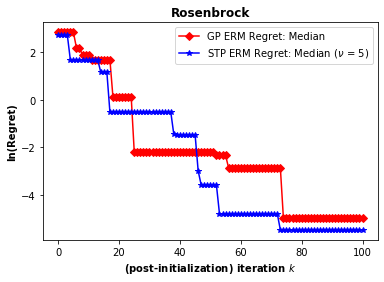

In [73]:
### 8(b). Regret minimisation plot: GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_6, label = 'GP ERM Regret: Median', marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_12, label = 'STP ERM Regret: Median ' r'($\nu$' ' = {})'.format(df1), marker = '*', color = 'Blue')

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


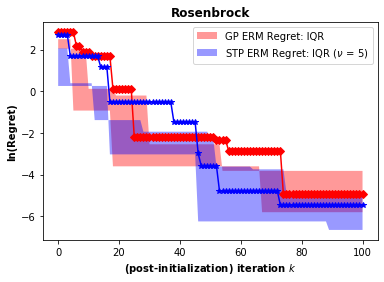

In [74]:
### 8(c). Regret minimisation plot: IQR GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_6, marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_12, marker = '*', color = 'Blue')

xstar = np.arange(0, 101, step=1)
plt.fill_between(xstar, train_regret_gp_14, train_regret_gp_4, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, train_regret_stp_df1_11, train_regret_stp_df1_17, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


In [75]:
# Iteration1 :

slice1 = 0

gp1 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp1 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]

lower_gp1, median_gp1, upper_gp1, lower_stp1, median_stp1, upper_stp1


(4.465863922875987,
 2.8293117007883186,
 2.038736147173563,
 4.465863922875987,
 2.8293117007883186,
 2.038736147173563)

In [76]:
# Iteration11 :

slice11 = 10

gp11 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp11 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]

lower_gp11, median_gp11, upper_gp11, lower_stp11, median_stp11, upper_stp11


(0.5625916257926228,
 -0.026971405705059574,
 -1.000871878711436,
 2.14947779733742,
 1.329082918870567,
 1.0017029551408791)

In [77]:
# Iteration21 :

slice21 = 20

gp21 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp21 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]

lower_gp21, median_gp21, upper_gp21, lower_stp21, median_stp21, upper_stp21


(-0.208363177769124,
 -1.274475222696904,
 -2.052180654175121,
 0.6216108281338706,
 -0.5175952818556977,
 -2.1904454410872676)

In [78]:
# Iteration31 :

slice31 = 30

gp31 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp31 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp31 = np.asarray(gp31_results[4:5][0])[0]
median_gp31 = np.asarray(gp31_results[9:10][0])[0]
upper_gp31 = np.asarray(gp31_results[14:15][0])[0]

lower_stp31 = np.asarray(stp31_results[4:5][0])[0]
median_stp31 = np.asarray(stp31_results[9:10][0])[0]
upper_stp31 = np.asarray(stp31_results[14:15][0])[0]

lower_gp31, median_gp31, upper_gp31, lower_stp31, median_stp31, upper_stp31


(-1.3487992463193132,
 -2.2817150034838853,
 -3.2052202609509837,
 -0.5175952818556977,
 -1.7566873445784115,
 -2.738923020326601)

In [79]:
# Iteration41 :

slice41 = 40

gp41 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp41 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp41_results = pd.DataFrame(gp41).sort_values(by=[0], ascending=False)
stp41_results = pd.DataFrame(stp41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp41 = np.asarray(gp41_results[4:5][0])[0]
median_gp41 = np.asarray(gp41_results[9:10][0])[0]
upper_gp41 = np.asarray(gp41_results[14:15][0])[0]

lower_stp41 = np.asarray(stp41_results[4:5][0])[0]
median_stp41 = np.asarray(stp41_results[9:10][0])[0]
upper_stp41 = np.asarray(stp41_results[14:15][0])[0]

lower_gp41, median_gp41, upper_gp41, lower_stp41, median_stp41, upper_stp41


(-2.043216882553417,
 -2.576818470829016,
 -3.2052202609509837,
 -1.4852585956582012,
 -2.2399794545981377,
 -3.046315615391803)

In [80]:
# Iteration51 :

slice51 = 50

gp51 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp51 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp51_results = pd.DataFrame(gp51).sort_values(by=[0], ascending=False)
stp51_results = pd.DataFrame(stp51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp51 = np.asarray(gp51_results[4:5][0])[0]
median_gp51 = np.asarray(gp51_results[9:10][0])[0]
upper_gp51 = np.asarray(gp51_results[14:15][0])[0]

lower_stp51 = np.asarray(stp51_results[4:5][0])[0]
median_stp51 = np.asarray(stp51_results[9:10][0])[0]
upper_stp51 = np.asarray(stp51_results[14:15][0])[0]

lower_gp51, median_gp51, upper_gp51, lower_stp51, median_stp51, upper_stp51


(-2.548486389313155,
 -3.387839435485708,
 -4.811180114806883,
 -3.0999172719175387,
 -3.6510894827713627,
 -4.201581819953229)

In [81]:
# Iteration61 :

slice61 = 60

gp61 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp61 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp61_results = pd.DataFrame(gp61).sort_values(by=[0], ascending=False)
stp61_results = pd.DataFrame(stp61).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp61 = np.asarray(gp61_results[4:5][0])[0]
median_gp61 = np.asarray(gp61_results[9:10][0])[0]
upper_gp61 = np.asarray(gp61_results[14:15][0])[0]

lower_stp61 = np.asarray(stp61_results[4:5][0])[0]
median_stp61 = np.asarray(stp61_results[9:10][0])[0]
upper_stp61 = np.asarray(stp61_results[14:15][0])[0]

lower_gp61, median_gp61, upper_gp61, lower_stp61, median_stp61, upper_stp61


(-2.8569412381127535,
 -3.5729738225166305,
 -4.811180114806883,
 -3.6510894827713627,
 -4.557464367596583,
 -5.571695061435701)

In [82]:
# Iteration71 :

slice71 = 70

gp71 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp71 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp71_results = pd.DataFrame(gp71).sort_values(by=[0], ascending=False)
stp71_results = pd.DataFrame(stp71).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp71 = np.asarray(gp71_results[4:5][0])[0]
median_gp71 = np.asarray(gp71_results[9:10][0])[0]
upper_gp71 = np.asarray(gp71_results[14:15][0])[0]

lower_stp71 = np.asarray(stp71_results[4:5][0])[0]
median_stp71 = np.asarray(stp71_results[9:10][0])[0]
upper_stp71 = np.asarray(stp71_results[14:15][0])[0]

lower_gp71, median_gp71, upper_gp71, lower_stp71, median_stp71, upper_stp71


(-3.1162744483056444,
 -3.5729738225166305,
 -5.426294075349022,
 -4.273469106263236,
 -4.725440108525788,
 -6.029286036209675)

In [83]:
# Iteration81 :

slice81 = 80

gp81 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp81 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp81_results = pd.DataFrame(gp81).sort_values(by=[0], ascending=False)
stp81_results = pd.DataFrame(stp81).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp81 = np.asarray(gp81_results[4:5][0])[0]
median_gp81 = np.asarray(gp81_results[9:10][0])[0]
upper_gp81 = np.asarray(gp81_results[14:15][0])[0]

lower_stp81 = np.asarray(stp81_results[4:5][0])[0]
median_stp81 = np.asarray(stp81_results[9:10][0])[0]
upper_stp81 = np.asarray(stp81_results[14:15][0])[0]

lower_gp81, median_gp81, upper_gp81, lower_stp81, median_stp81, upper_stp81

(-3.5271283016889377,
 -4.811180114806883,
 -5.774243280230393,
 -4.612434374652544,
 -5.235169480342767,
 -6.25090236822877)

In [84]:
# Iteration91 :

slice1 = 90

gp91 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp91 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp91_results = pd.DataFrame(gp91).sort_values(by=[0], ascending=False)
stp91_results = pd.DataFrame(stp91).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp91 = np.asarray(gp91_results[4:5][0])[0]
median_gp91 = np.asarray(gp91_results[9:10][0])[0]
upper_gp91 = np.asarray(gp91_results[14:15][0])[0]

lower_stp91 = np.asarray(stp91_results[4:5][0])[0]
median_stp91 = np.asarray(stp91_results[9:10][0])[0]
upper_stp91 = np.asarray(stp91_results[14:15][0])[0]

lower_gp91, median_gp91, upper_gp91, lower_stp91, median_stp91, upper_stp91


(-3.711865895026006,
 -4.885139440616033,
 -5.8086569761712905,
 -4.871495191540244,
 -5.460181814912429,
 -6.658817289219496)

In [85]:
# Iteration101 :

slice1 = 100

gp101 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp101 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp101_results = pd.DataFrame(gp101).sort_values(by=[0], ascending=False)
stp101_results = pd.DataFrame(stp101).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp101 = np.asarray(gp101_results[4:5][0])[0]
median_gp101 = np.asarray(gp101_results[9:10][0])[0]
upper_gp101 = np.asarray(gp101_results[14:15][0])[0]

lower_stp101 = np.asarray(stp101_results[4:5][0])[0]
median_stp101 = np.asarray(stp101_results[9:10][0])[0]
upper_stp101 = np.asarray(stp101_results[14:15][0])[0]

lower_gp101, median_gp101, upper_gp101, lower_stp101, median_stp101, upper_stp101


(-3.8251876066440342,
 -4.957978184518829,
 -5.8086569761712905,
 -4.871495191540244,
 -5.460181814912429,
 -6.658817289219496)

In [86]:
# Iteration2 :

slice1 = 1

gp2 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp2 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [87]:
# Iteration12 :

slice11 = 11

gp12 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp12 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [88]:
# Iteration22 :

slice21 = 21

gp22 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp22 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp22 = np.asarray(gp22_results[4:5][0])[0]
median_gp22 = np.asarray(gp22_results[9:10][0])[0]
upper_gp22 = np.asarray(gp22_results[14:15][0])[0]

lower_stp22 = np.asarray(stp22_results[4:5][0])[0]
median_stp22 = np.asarray(stp22_results[9:10][0])[0]
upper_stp22 = np.asarray(stp22_results[14:15][0])[0]


In [89]:
# Iteration32 :

slice31 = 31

gp32 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp32 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp32_results = pd.DataFrame(gp32).sort_values(by=[0], ascending=False)
stp32_results = pd.DataFrame(stp32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp32 = np.asarray(gp32_results[4:5][0])[0]
median_gp32 = np.asarray(gp32_results[9:10][0])[0]
upper_gp32 = np.asarray(gp32_results[14:15][0])[0]

lower_stp32 = np.asarray(stp32_results[4:5][0])[0]
median_stp32 = np.asarray(stp32_results[9:10][0])[0]
upper_stp32 = np.asarray(stp32_results[14:15][0])[0]


In [90]:
# Iteration42 :

slice41 = 41

gp42 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp42 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp42_results = pd.DataFrame(gp42).sort_values(by=[0], ascending=False)
stp42_results = pd.DataFrame(stp42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp42 = np.asarray(gp42_results[4:5][0])[0]
median_gp42 = np.asarray(gp42_results[9:10][0])[0]
upper_gp42 = np.asarray(gp42_results[14:15][0])[0]

lower_stp42 = np.asarray(stp42_results[4:5][0])[0]
median_stp42 = np.asarray(stp42_results[9:10][0])[0]
upper_stp42 = np.asarray(stp42_results[14:15][0])[0]


In [91]:
# Iteration52 :

slice51 = 51

gp52 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp52 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp52_results = pd.DataFrame(gp52).sort_values(by=[0], ascending=False)
stp52_results = pd.DataFrame(stp52).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp52 = np.asarray(gp52_results[4:5][0])[0]
median_gp52 = np.asarray(gp52_results[9:10][0])[0]
upper_gp52 = np.asarray(gp52_results[14:15][0])[0]

lower_stp52 = np.asarray(stp52_results[4:5][0])[0]
median_stp52 = np.asarray(stp52_results[9:10][0])[0]
upper_stp52 = np.asarray(stp52_results[14:15][0])[0]


In [92]:
# Iteration62 :

slice61 = 61

gp62 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp62 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp62_results = pd.DataFrame(gp62).sort_values(by=[0], ascending=False)
stp62_results = pd.DataFrame(stp62).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp62 = np.asarray(gp62_results[4:5][0])[0]
median_gp62 = np.asarray(gp62_results[9:10][0])[0]
upper_gp62 = np.asarray(gp62_results[14:15][0])[0]

lower_stp62 = np.asarray(stp62_results[4:5][0])[0]
median_stp62 = np.asarray(stp62_results[9:10][0])[0]
upper_stp62 = np.asarray(stp62_results[14:15][0])[0]


In [93]:
# Iteration72 :

slice71 = 71

gp72 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp72 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp72_results = pd.DataFrame(gp72).sort_values(by=[0], ascending=False)
stp72_results = pd.DataFrame(stp72).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp72 = np.asarray(gp72_results[4:5][0])[0]
median_gp72 = np.asarray(gp72_results[9:10][0])[0]
upper_gp72 = np.asarray(gp72_results[14:15][0])[0]

lower_stp72 = np.asarray(stp72_results[4:5][0])[0]
median_stp72 = np.asarray(stp72_results[9:10][0])[0]
upper_stp72 = np.asarray(stp72_results[14:15][0])[0]


In [94]:
# Iteration82 :

slice81 = 81

gp82 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp82 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp82_results = pd.DataFrame(gp82).sort_values(by=[0], ascending=False)
stp82_results = pd.DataFrame(stp82).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp82 = np.asarray(gp82_results[4:5][0])[0]
median_gp82 = np.asarray(gp82_results[9:10][0])[0]
upper_gp82 = np.asarray(gp82_results[14:15][0])[0]

lower_stp82 = np.asarray(stp82_results[4:5][0])[0]
median_stp82 = np.asarray(stp82_results[9:10][0])[0]
upper_stp82 = np.asarray(stp82_results[14:15][0])[0]


In [95]:
# Iteration92 :

slice1 = 91

gp92 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp92 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp92_results = pd.DataFrame(gp92).sort_values(by=[0], ascending=False)
stp92_results = pd.DataFrame(stp92).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp92 = np.asarray(gp92_results[4:5][0])[0]
median_gp92 = np.asarray(gp92_results[9:10][0])[0]
upper_gp92 = np.asarray(gp92_results[14:15][0])[0]

lower_stp92 = np.asarray(stp92_results[4:5][0])[0]
median_stp92 = np.asarray(stp92_results[9:10][0])[0]
upper_stp92 = np.asarray(stp92_results[14:15][0])[0]



In [96]:
# Iteration3 :

slice1 = 2

gp3 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp3 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [97]:
# Iteration13 :

slice11 = 12

gp13 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp13 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [98]:
# Iteration23 :

slice21 = 22

gp23 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp23 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp23 = np.asarray(gp23_results[4:5][0])[0]
median_gp23 = np.asarray(gp23_results[9:10][0])[0]
upper_gp23 = np.asarray(gp23_results[14:15][0])[0]

lower_stp23 = np.asarray(stp23_results[4:5][0])[0]
median_stp23 = np.asarray(stp23_results[9:10][0])[0]
upper_stp23 = np.asarray(stp23_results[14:15][0])[0]


In [99]:
# Iteration33 :

slice31 = 32

gp33 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp33 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp33_results = pd.DataFrame(gp33).sort_values(by=[0], ascending=False)
stp33_results = pd.DataFrame(stp33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp33 = np.asarray(gp33_results[4:5][0])[0]
median_gp33 = np.asarray(gp33_results[9:10][0])[0]
upper_gp33 = np.asarray(gp33_results[14:15][0])[0]

lower_stp33 = np.asarray(stp33_results[4:5][0])[0]
median_stp33 = np.asarray(stp33_results[9:10][0])[0]
upper_stp33 = np.asarray(stp33_results[14:15][0])[0]


In [100]:
# Iteration43 :

slice41 = 42

gp43 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp43 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp43_results = pd.DataFrame(gp43).sort_values(by=[0], ascending=False)
stp43_results = pd.DataFrame(stp43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp43 = np.asarray(gp43_results[4:5][0])[0]
median_gp43 = np.asarray(gp43_results[9:10][0])[0]
upper_gp43 = np.asarray(gp43_results[14:15][0])[0]

lower_stp43 = np.asarray(stp43_results[4:5][0])[0]
median_stp43 = np.asarray(stp43_results[9:10][0])[0]
upper_stp43 = np.asarray(stp43_results[14:15][0])[0]


In [101]:
# Iteration53 :

slice51 = 52

gp53 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp53 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp53_results = pd.DataFrame(gp53).sort_values(by=[0], ascending=False)
stp53_results = pd.DataFrame(stp53).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp53 = np.asarray(gp53_results[4:5][0])[0]
median_gp53 = np.asarray(gp53_results[9:10][0])[0]
upper_gp53 = np.asarray(gp53_results[14:15][0])[0]

lower_stp53 = np.asarray(stp53_results[4:5][0])[0]
median_stp53 = np.asarray(stp53_results[9:10][0])[0]
upper_stp53 = np.asarray(stp53_results[14:15][0])[0]


In [102]:
# Iteration63 :

slice61 = 62

gp63 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp63 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp63_results = pd.DataFrame(gp63).sort_values(by=[0], ascending=False)
stp63_results = pd.DataFrame(stp63).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp63 = np.asarray(gp63_results[4:5][0])[0]
median_gp63 = np.asarray(gp63_results[9:10][0])[0]
upper_gp63 = np.asarray(gp63_results[14:15][0])[0]

lower_stp63 = np.asarray(stp63_results[4:5][0])[0]
median_stp63 = np.asarray(stp63_results[9:10][0])[0]
upper_stp63 = np.asarray(stp63_results[14:15][0])[0]


In [103]:
# Iteration73 :

slice71 = 72

gp73 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp73 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp73_results = pd.DataFrame(gp73).sort_values(by=[0], ascending=False)
stp73_results = pd.DataFrame(stp73).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp73 = np.asarray(gp73_results[4:5][0])[0]
median_gp73 = np.asarray(gp73_results[9:10][0])[0]
upper_gp73 = np.asarray(gp73_results[14:15][0])[0]

lower_stp73 = np.asarray(stp73_results[4:5][0])[0]
median_stp73 = np.asarray(stp73_results[9:10][0])[0]
upper_stp73 = np.asarray(stp73_results[14:15][0])[0]


In [104]:
# Iteration83 :

slice81 = 82

gp83 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp83 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp83_results = pd.DataFrame(gp83).sort_values(by=[0], ascending=False)
stp83_results = pd.DataFrame(stp83).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp83 = np.asarray(gp83_results[4:5][0])[0]
median_gp83 = np.asarray(gp83_results[9:10][0])[0]
upper_gp83 = np.asarray(gp83_results[14:15][0])[0]

lower_stp83 = np.asarray(stp83_results[4:5][0])[0]
median_stp83 = np.asarray(stp83_results[9:10][0])[0]
upper_stp83 = np.asarray(stp83_results[14:15][0])[0]


In [105]:
# Iteration93 :

slice1 = 92

gp93 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp93 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp93_results = pd.DataFrame(gp93).sort_values(by=[0], ascending=False)
stp93_results = pd.DataFrame(stp93).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp93 = np.asarray(gp93_results[4:5][0])[0]
median_gp93 = np.asarray(gp93_results[9:10][0])[0]
upper_gp93 = np.asarray(gp93_results[14:15][0])[0]

lower_stp93 = np.asarray(stp93_results[4:5][0])[0]
median_stp93 = np.asarray(stp93_results[9:10][0])[0]
upper_stp93 = np.asarray(stp93_results[14:15][0])[0]



In [106]:
# Iteration4 :

slice1 = 3

gp4 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp4 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [107]:
# Iteration14 :

slice11 = 13

gp14 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp14 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [108]:
# Iteration24 :

slice21 = 23

gp24 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp24 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp24 = np.asarray(gp24_results[4:5][0])[0]
median_gp24 = np.asarray(gp24_results[9:10][0])[0]
upper_gp24 = np.asarray(gp24_results[14:15][0])[0]

lower_stp24 = np.asarray(stp24_results[4:5][0])[0]
median_stp24 = np.asarray(stp24_results[9:10][0])[0]
upper_stp24 = np.asarray(stp24_results[14:15][0])[0]


In [109]:
# Iteration34 :

slice31 = 33

gp34 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp34 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp34_results = pd.DataFrame(gp34).sort_values(by=[0], ascending=False)
stp34_results = pd.DataFrame(stp34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp34 = np.asarray(gp34_results[4:5][0])[0]
median_gp34 = np.asarray(gp34_results[9:10][0])[0]
upper_gp34 = np.asarray(gp34_results[14:15][0])[0]

lower_stp34 = np.asarray(stp34_results[4:5][0])[0]
median_stp34 = np.asarray(stp34_results[9:10][0])[0]
upper_stp34 = np.asarray(stp34_results[14:15][0])[0]


In [110]:
# Iteration44 :

slice41 = 43

gp44 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp44 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp44_results = pd.DataFrame(gp44).sort_values(by=[0], ascending=False)
stp44_results = pd.DataFrame(stp44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp44 = np.asarray(gp44_results[4:5][0])[0]
median_gp44 = np.asarray(gp44_results[9:10][0])[0]
upper_gp44 = np.asarray(gp44_results[14:15][0])[0]

lower_stp44 = np.asarray(stp44_results[4:5][0])[0]
median_stp44 = np.asarray(stp44_results[9:10][0])[0]
upper_stp44 = np.asarray(stp44_results[14:15][0])[0]


In [111]:
# Iteration54 :

slice51 = 53

gp54 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp54 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp54_results = pd.DataFrame(gp54).sort_values(by=[0], ascending=False)
stp54_results = pd.DataFrame(stp54).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp54 = np.asarray(gp54_results[4:5][0])[0]
median_gp54 = np.asarray(gp54_results[9:10][0])[0]
upper_gp54 = np.asarray(gp54_results[14:15][0])[0]

lower_stp54 = np.asarray(stp54_results[4:5][0])[0]
median_stp54 = np.asarray(stp54_results[9:10][0])[0]
upper_stp54 = np.asarray(stp54_results[14:15][0])[0]


In [112]:
# Iteration64 :

slice61 = 63

gp64 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp64 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp64_results = pd.DataFrame(gp64).sort_values(by=[0], ascending=False)
stp64_results = pd.DataFrame(stp64).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp64 = np.asarray(gp64_results[4:5][0])[0]
median_gp64 = np.asarray(gp64_results[9:10][0])[0]
upper_gp64 = np.asarray(gp64_results[14:15][0])[0]

lower_stp64 = np.asarray(stp64_results[4:5][0])[0]
median_stp64 = np.asarray(stp64_results[9:10][0])[0]
upper_stp64 = np.asarray(stp64_results[14:15][0])[0]


In [113]:
# Iteration74 :

slice71 = 73

gp74 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp74 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp74_results = pd.DataFrame(gp74).sort_values(by=[0], ascending=False)
stp74_results = pd.DataFrame(stp74).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp74 = np.asarray(gp74_results[4:5][0])[0]
median_gp74 = np.asarray(gp74_results[9:10][0])[0]
upper_gp74 = np.asarray(gp74_results[14:15][0])[0]

lower_stp74 = np.asarray(stp74_results[4:5][0])[0]
median_stp74 = np.asarray(stp74_results[9:10][0])[0]
upper_stp74 = np.asarray(stp74_results[14:15][0])[0]


In [114]:
# Iteration84 :

slice81 = 83

gp84 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp84 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp84_results = pd.DataFrame(gp84).sort_values(by=[0], ascending=False)
stp84_results = pd.DataFrame(stp84).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp84 = np.asarray(gp84_results[4:5][0])[0]
median_gp84 = np.asarray(gp84_results[9:10][0])[0]
upper_gp84 = np.asarray(gp84_results[14:15][0])[0]

lower_stp84 = np.asarray(stp84_results[4:5][0])[0]
median_stp84 = np.asarray(stp84_results[9:10][0])[0]
upper_stp84 = np.asarray(stp84_results[14:15][0])[0]


In [115]:
# Iteration94 :

slice1 = 93

gp94 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp94 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp94_results = pd.DataFrame(gp94).sort_values(by=[0], ascending=False)
stp94_results = pd.DataFrame(stp94).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp94 = np.asarray(gp94_results[4:5][0])[0]
median_gp94 = np.asarray(gp94_results[9:10][0])[0]
upper_gp94 = np.asarray(gp94_results[14:15][0])[0]

lower_stp94 = np.asarray(stp94_results[4:5][0])[0]
median_stp94 = np.asarray(stp94_results[9:10][0])[0]
upper_stp94 = np.asarray(stp94_results[14:15][0])[0]



In [116]:
# Iteration5 :

slice1 = 4

gp5 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp5 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [117]:
# Iteration15 :

slice11 = 14

gp15 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp15 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [118]:
# Iteration25 :

slice21 = 24

gp25 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp25 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp25 = np.asarray(gp25_results[4:5][0])[0]
median_gp25 = np.asarray(gp25_results[9:10][0])[0]
upper_gp25 = np.asarray(gp25_results[14:15][0])[0]

lower_stp25 = np.asarray(stp25_results[4:5][0])[0]
median_stp25 = np.asarray(stp25_results[9:10][0])[0]
upper_stp25= np.asarray(stp25_results[14:15][0])[0]


In [119]:
# Iteration35 :

slice31 = 34

gp35 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp35 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp35_results = pd.DataFrame(gp35).sort_values(by=[0], ascending=False)
stp35_results = pd.DataFrame(stp35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp35 = np.asarray(gp35_results[4:5][0])[0]
median_gp35 = np.asarray(gp35_results[9:10][0])[0]
upper_gp35 = np.asarray(gp35_results[14:15][0])[0]

lower_stp35 = np.asarray(stp35_results[4:5][0])[0]
median_stp35 = np.asarray(stp35_results[9:10][0])[0]
upper_stp35 = np.asarray(stp35_results[14:15][0])[0]


In [120]:
# Iteration45 :

slice41 = 44

gp45 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp45 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp45_results = pd.DataFrame(gp45).sort_values(by=[0], ascending=False)
stp45_results = pd.DataFrame(stp45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp45 = np.asarray(gp45_results[4:5][0])[0]
median_gp45 = np.asarray(gp45_results[9:10][0])[0]
upper_gp45 = np.asarray(gp45_results[14:15][0])[0]

lower_stp45 = np.asarray(stp45_results[4:5][0])[0]
median_stp45 = np.asarray(stp45_results[9:10][0])[0]
upper_stp45 = np.asarray(stp45_results[14:15][0])[0]


In [121]:
# Iteration55 :

slice51 = 54

gp55 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp55 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp55_results = pd.DataFrame(gp55).sort_values(by=[0], ascending=False)
stp55_results = pd.DataFrame(stp55).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp55 = np.asarray(gp55_results[4:5][0])[0]
median_gp55 = np.asarray(gp55_results[9:10][0])[0]
upper_gp55 = np.asarray(gp55_results[14:15][0])[0]

lower_stp55 = np.asarray(stp55_results[4:5][0])[0]
median_stp55 = np.asarray(stp55_results[9:10][0])[0]
upper_stp55 = np.asarray(stp55_results[14:15][0])[0]


In [122]:
# Iteration65 :

slice61 = 64

gp65 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp65 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp65_results = pd.DataFrame(gp65).sort_values(by=[0], ascending=False)
stp65_results = pd.DataFrame(stp65).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp65 = np.asarray(gp65_results[4:5][0])[0]
median_gp65 = np.asarray(gp65_results[9:10][0])[0]
upper_gp65 = np.asarray(gp65_results[14:15][0])[0]

lower_stp65 = np.asarray(stp65_results[4:5][0])[0]
median_stp65 = np.asarray(stp65_results[9:10][0])[0]
upper_stp65 = np.asarray(stp65_results[14:15][0])[0]


In [123]:
# Iteration75 :

slice71 = 74

gp75 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp75 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp75_results = pd.DataFrame(gp75).sort_values(by=[0], ascending=False)
stp75_results = pd.DataFrame(stp75).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp75 = np.asarray(gp75_results[4:5][0])[0]
median_gp75 = np.asarray(gp75_results[9:10][0])[0]
upper_gp75 = np.asarray(gp75_results[14:15][0])[0]

lower_stp75 = np.asarray(stp75_results[4:5][0])[0]
median_stp75 = np.asarray(stp75_results[9:10][0])[0]
upper_stp75 = np.asarray(stp75_results[14:15][0])[0]


In [124]:
# Iteration85 :

slice81 = 84

gp85 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp85 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp85_results = pd.DataFrame(gp85).sort_values(by=[0], ascending=False)
stp85_results = pd.DataFrame(stp85).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp85 = np.asarray(gp85_results[4:5][0])[0]
median_gp85 = np.asarray(gp85_results[9:10][0])[0]
upper_gp85 = np.asarray(gp85_results[14:15][0])[0]

lower_stp85 = np.asarray(stp85_results[4:5][0])[0]
median_stp85 = np.asarray(stp85_results[9:10][0])[0]
upper_stp85 = np.asarray(stp85_results[14:15][0])[0]


In [125]:
# Iteration95 :

slice1 = 94

gp95 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp95 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp95_results = pd.DataFrame(gp95).sort_values(by=[0], ascending=False)
stp95_results = pd.DataFrame(stp95).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp95 = np.asarray(gp95_results[4:5][0])[0]
median_gp95 = np.asarray(gp95_results[9:10][0])[0]
upper_gp95 = np.asarray(gp95_results[14:15][0])[0]

lower_stp95 = np.asarray(stp95_results[4:5][0])[0]
median_stp95 = np.asarray(stp95_results[9:10][0])[0]
upper_stp95 = np.asarray(stp95_results[14:15][0])[0]



In [126]:
# Iteration6 :

slice1 = 5

gp6 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp6 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [127]:
# Iteration16 :

slice11 = 15

gp16 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp16 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [128]:
# Iteration26 :

slice21 = 25

gp26 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp26 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp26 = np.asarray(gp26_results[4:5][0])[0]
median_gp26 = np.asarray(gp26_results[9:10][0])[0]
upper_gp26 = np.asarray(gp26_results[14:15][0])[0]

lower_stp26 = np.asarray(stp26_results[4:5][0])[0]
median_stp26 = np.asarray(stp26_results[9:10][0])[0]
upper_stp26 = np.asarray(stp26_results[14:15][0])[0]


In [129]:
# Iteration36 :

slice31 = 35

gp36 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp36 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp36_results = pd.DataFrame(gp36).sort_values(by=[0], ascending=False)
stp36_results = pd.DataFrame(stp36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp36 = np.asarray(gp36_results[4:5][0])[0]
median_gp36 = np.asarray(gp36_results[9:10][0])[0]
upper_gp36 = np.asarray(gp36_results[14:15][0])[0]

lower_stp36 = np.asarray(stp36_results[4:5][0])[0]
median_stp36 = np.asarray(stp36_results[9:10][0])[0]
upper_stp36 = np.asarray(stp36_results[14:15][0])[0]


In [130]:
# Iteration46 :

slice41 = 45

gp46 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp46 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp46_results = pd.DataFrame(gp46).sort_values(by=[0], ascending=False)
stp46_results = pd.DataFrame(stp46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp46 = np.asarray(gp46_results[4:5][0])[0]
median_gp46 = np.asarray(gp46_results[9:10][0])[0]
upper_gp46 = np.asarray(gp46_results[14:15][0])[0]

lower_stp46 = np.asarray(stp46_results[4:5][0])[0]
median_stp46 = np.asarray(stp46_results[9:10][0])[0]
upper_stp46 = np.asarray(stp46_results[14:15][0])[0]


In [131]:
# Iteration56 :

slice51 = 55

gp56 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp56 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp56_results = pd.DataFrame(gp56).sort_values(by=[0], ascending=False)
stp56_results = pd.DataFrame(stp56).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp56 = np.asarray(gp56_results[4:5][0])[0]
median_gp56 = np.asarray(gp56_results[9:10][0])[0]
upper_gp56 = np.asarray(gp56_results[14:15][0])[0]

lower_stp56 = np.asarray(stp56_results[4:5][0])[0]
median_stp56 = np.asarray(stp56_results[9:10][0])[0]
upper_stp56 = np.asarray(stp56_results[14:15][0])[0]


In [132]:
# Iteration66 :

slice61 = 65

gp66 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp66 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp66_results = pd.DataFrame(gp66).sort_values(by=[0], ascending=False)
stp66_results = pd.DataFrame(stp66).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp66 = np.asarray(gp66_results[4:5][0])[0]
median_gp66 = np.asarray(gp66_results[9:10][0])[0]
upper_gp66 = np.asarray(gp66_results[14:15][0])[0]

lower_stp66 = np.asarray(stp66_results[4:5][0])[0]
median_stp66 = np.asarray(stp66_results[9:10][0])[0]
upper_stp66 = np.asarray(stp66_results[14:15][0])[0]


In [133]:
# Iteration76 :

slice71 = 75

gp76 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp76 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp76_results = pd.DataFrame(gp76).sort_values(by=[0], ascending=False)
stp76_results = pd.DataFrame(stp76).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp76 = np.asarray(gp76_results[4:5][0])[0]
median_gp76 = np.asarray(gp76_results[9:10][0])[0]
upper_gp76 = np.asarray(gp76_results[14:15][0])[0]

lower_stp76 = np.asarray(stp76_results[4:5][0])[0]
median_stp76 = np.asarray(stp76_results[9:10][0])[0]
upper_stp76 = np.asarray(stp76_results[14:15][0])[0]


In [134]:
# Iteration86 :

slice81 = 85

gp86 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp86 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp86_results = pd.DataFrame(gp86).sort_values(by=[0], ascending=False)
stp86_results = pd.DataFrame(stp86).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp86 = np.asarray(gp86_results[4:5][0])[0]
median_gp86 = np.asarray(gp86_results[9:10][0])[0]
upper_gp86 = np.asarray(gp86_results[14:15][0])[0]

lower_stp86 = np.asarray(stp86_results[4:5][0])[0]
median_stp86 = np.asarray(stp86_results[9:10][0])[0]
upper_stp86 = np.asarray(stp86_results[14:15][0])[0]


In [135]:
# Iteration96 :

slice1 = 95

gp96 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp96 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp96_results = pd.DataFrame(gp96).sort_values(by=[0], ascending=False)
stp96_results = pd.DataFrame(stp96).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp96 = np.asarray(gp96_results[4:5][0])[0]
median_gp96 = np.asarray(gp96_results[9:10][0])[0]
upper_gp96 = np.asarray(gp96_results[14:15][0])[0]

lower_stp96 = np.asarray(stp96_results[4:5][0])[0]
median_stp96 = np.asarray(stp96_results[9:10][0])[0]
upper_stp96 = np.asarray(stp96_results[14:15][0])[0]



In [136]:
# Iteration7 :

slice1 = 6

gp7 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp7 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [137]:
# Iteration17 :

slice11 = 16

gp17 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp17 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [138]:
# Iteration27 :

slice21 = 26

gp27 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp27 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp27 = np.asarray(gp27_results[4:5][0])[0]
median_gp27 = np.asarray(gp27_results[9:10][0])[0]
upper_gp27 = np.asarray(gp27_results[14:15][0])[0]

lower_stp27 = np.asarray(stp27_results[4:5][0])[0]
median_stp27 = np.asarray(stp27_results[9:10][0])[0]
upper_stp27 = np.asarray(stp27_results[14:15][0])[0]


In [139]:
# Iteration37 :

slice31 = 36

gp37 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp37 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp37_results = pd.DataFrame(gp37).sort_values(by=[0], ascending=False)
stp37_results = pd.DataFrame(stp37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp37 = np.asarray(gp37_results[4:5][0])[0]
median_gp37 = np.asarray(gp37_results[9:10][0])[0]
upper_gp37 = np.asarray(gp37_results[14:15][0])[0]

lower_stp37 = np.asarray(stp37_results[4:5][0])[0]
median_stp37 = np.asarray(stp37_results[9:10][0])[0]
upper_stp37 = np.asarray(stp37_results[14:15][0])[0]


In [140]:
# Iteration47 :

slice41 = 46

gp47 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp47 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp47_results = pd.DataFrame(gp47).sort_values(by=[0], ascending=False)
stp47_results = pd.DataFrame(stp47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp47 = np.asarray(gp47_results[4:5][0])[0]
median_gp47 = np.asarray(gp47_results[9:10][0])[0]
upper_gp47 = np.asarray(gp47_results[14:15][0])[0]

lower_stp47 = np.asarray(stp47_results[4:5][0])[0]
median_stp47 = np.asarray(stp47_results[9:10][0])[0]
upper_stp47 = np.asarray(stp47_results[14:15][0])[0]


In [141]:
# Iteration57 :

slice51 = 56

gp57 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp57 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp57_results = pd.DataFrame(gp57).sort_values(by=[0], ascending=False)
stp57_results = pd.DataFrame(stp57).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp57 = np.asarray(gp57_results[4:5][0])[0]
median_gp57 = np.asarray(gp57_results[9:10][0])[0]
upper_gp57 = np.asarray(gp57_results[14:15][0])[0]

lower_stp57 = np.asarray(stp57_results[4:5][0])[0]
median_stp57 = np.asarray(stp57_results[9:10][0])[0]
upper_stp57 = np.asarray(stp57_results[14:15][0])[0]


In [142]:
# Iteration67 :

slice61 = 66

gp67 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp67 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp67_results = pd.DataFrame(gp67).sort_values(by=[0], ascending=False)
stp67_results = pd.DataFrame(stp67).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp67 = np.asarray(gp67_results[4:5][0])[0]
median_gp67 = np.asarray(gp67_results[9:10][0])[0]
upper_gp67 = np.asarray(gp67_results[14:15][0])[0]

lower_stp67 = np.asarray(stp67_results[4:5][0])[0]
median_stp67 = np.asarray(stp67_results[9:10][0])[0]
upper_stp67 = np.asarray(stp67_results[14:15][0])[0]


In [143]:
# Iteration77 :

slice71 = 76

gp77 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp77 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp77_results = pd.DataFrame(gp77).sort_values(by=[0], ascending=False)
stp77_results = pd.DataFrame(stp77).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp77 = np.asarray(gp77_results[4:5][0])[0]
median_gp77 = np.asarray(gp77_results[9:10][0])[0]
upper_gp77 = np.asarray(gp77_results[14:15][0])[0]

lower_stp77 = np.asarray(stp77_results[4:5][0])[0]
median_stp77 = np.asarray(stp77_results[9:10][0])[0]
upper_stp77 = np.asarray(stp77_results[14:15][0])[0]


In [144]:
# Iteration87 :

slice81 = 86

gp87 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp87 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp87_results = pd.DataFrame(gp87).sort_values(by=[0], ascending=False)
stp87_results = pd.DataFrame(stp87).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp87 = np.asarray(gp87_results[4:5][0])[0]
median_gp87 = np.asarray(gp87_results[9:10][0])[0]
upper_gp87 = np.asarray(gp87_results[14:15][0])[0]

lower_stp87 = np.asarray(stp87_results[4:5][0])[0]
median_stp87 = np.asarray(stp87_results[9:10][0])[0]
upper_stp87 = np.asarray(stp87_results[14:15][0])[0]


In [145]:
# Iteration97 :

slice1 = 96

gp97 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp97 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp97_results = pd.DataFrame(gp97).sort_values(by=[0], ascending=False)
stp97_results = pd.DataFrame(stp97).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp97 = np.asarray(gp97_results[4:5][0])[0]
median_gp97 = np.asarray(gp97_results[9:10][0])[0]
upper_gp97 = np.asarray(gp97_results[14:15][0])[0]

lower_stp97 = np.asarray(stp97_results[4:5][0])[0]
median_stp97 = np.asarray(stp97_results[9:10][0])[0]
upper_stp97 = np.asarray(stp97_results[14:15][0])[0]



In [146]:
# Iteration8 :

slice1 = 7

gp8 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp8 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [147]:
# Iteration18 :

slice11 = 17

gp18 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp18 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [148]:
# Iteration28 :

slice21 = 27

gp28 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp28 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp28 = np.asarray(gp28_results[4:5][0])[0]
median_gp28 = np.asarray(gp28_results[9:10][0])[0]
upper_gp28 = np.asarray(gp28_results[14:15][0])[0]

lower_stp28 = np.asarray(stp28_results[4:5][0])[0]
median_stp28 = np.asarray(stp28_results[9:10][0])[0]
upper_stp28 = np.asarray(stp28_results[14:15][0])[0]


In [149]:
# Iteration38 :

slice31 = 37

gp38 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp38 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp38_results = pd.DataFrame(gp38).sort_values(by=[0], ascending=False)
stp38_results = pd.DataFrame(stp38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp38 = np.asarray(gp38_results[4:5][0])[0]
median_gp38 = np.asarray(gp38_results[9:10][0])[0]
upper_gp38 = np.asarray(gp38_results[14:15][0])[0]

lower_stp38 = np.asarray(stp38_results[4:5][0])[0]
median_stp38 = np.asarray(stp38_results[9:10][0])[0]
upper_stp38 = np.asarray(stp38_results[14:15][0])[0]


In [150]:
# Iteration48 :

slice41 = 47

gp48 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp48 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp48_results = pd.DataFrame(gp48).sort_values(by=[0], ascending=False)
stp48_results = pd.DataFrame(stp48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp48 = np.asarray(gp48_results[4:5][0])[0]
median_gp48 = np.asarray(gp48_results[9:10][0])[0]
upper_gp48 = np.asarray(gp48_results[14:15][0])[0]

lower_stp48 = np.asarray(stp48_results[4:5][0])[0]
median_stp48 = np.asarray(stp48_results[9:10][0])[0]
upper_stp48 = np.asarray(stp48_results[14:15][0])[0]


In [151]:
# Iteration58 :

slice51 = 57

gp58 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp58 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp58_results = pd.DataFrame(gp58).sort_values(by=[0], ascending=False)
stp58_results = pd.DataFrame(stp58).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp58 = np.asarray(gp58_results[4:5][0])[0]
median_gp58 = np.asarray(gp58_results[9:10][0])[0]
upper_gp58 = np.asarray(gp58_results[14:15][0])[0]

lower_stp58 = np.asarray(stp58_results[4:5][0])[0]
median_stp58 = np.asarray(stp58_results[9:10][0])[0]
upper_stp58 = np.asarray(stp58_results[14:15][0])[0]


In [152]:
# Iteration68 :

slice61 = 67

gp68 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp68 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp68_results = pd.DataFrame(gp68).sort_values(by=[0], ascending=False)
stp68_results = pd.DataFrame(stp68).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp68 = np.asarray(gp68_results[4:5][0])[0]
median_gp68 = np.asarray(gp68_results[9:10][0])[0]
upper_gp68 = np.asarray(gp68_results[14:15][0])[0]

lower_stp68 = np.asarray(stp68_results[4:5][0])[0]
median_stp68 = np.asarray(stp68_results[9:10][0])[0]
upper_stp68 = np.asarray(stp68_results[14:15][0])[0]


In [153]:
# Iteration78 :

slice71 = 77

gp78 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp78 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp78_results = pd.DataFrame(gp78).sort_values(by=[0], ascending=False)
stp78_results = pd.DataFrame(stp78).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp78 = np.asarray(gp78_results[4:5][0])[0]
median_gp78 = np.asarray(gp78_results[9:10][0])[0]
upper_gp78 = np.asarray(gp78_results[14:15][0])[0]

lower_stp78 = np.asarray(stp78_results[4:5][0])[0]
median_stp78 = np.asarray(stp78_results[9:10][0])[0]
upper_stp78 = np.asarray(stp78_results[14:15][0])[0]


In [154]:
# Iteration88 :

slice81 = 87

gp88 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp88 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp88_results = pd.DataFrame(gp88).sort_values(by=[0], ascending=False)
stp88_results = pd.DataFrame(stp88).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp88 = np.asarray(gp88_results[4:5][0])[0]
median_gp88 = np.asarray(gp88_results[9:10][0])[0]
upper_gp88 = np.asarray(gp88_results[14:15][0])[0]

lower_stp88 = np.asarray(stp88_results[4:5][0])[0]
median_stp88 = np.asarray(stp88_results[9:10][0])[0]
upper_stp88 = np.asarray(stp88_results[14:15][0])[0]


In [155]:
# Iteration98 :

slice1 = 97

gp98 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp98 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp98_results = pd.DataFrame(gp98).sort_values(by=[0], ascending=False)
stp98_results = pd.DataFrame(stp98).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp98 = np.asarray(gp98_results[4:5][0])[0]
median_gp98 = np.asarray(gp98_results[9:10][0])[0]
upper_gp98 = np.asarray(gp98_results[14:15][0])[0]

lower_stp98 = np.asarray(stp98_results[4:5][0])[0]
median_stp98 = np.asarray(stp98_results[9:10][0])[0]
upper_stp98 = np.asarray(stp98_results[14:15][0])[0]



In [156]:
# Iteration9 :

slice1 = 8

gp9 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp9 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [157]:
# Iteration19 :

slice11 = 18

gp19 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp19 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [158]:
# Iteration29 :

slice21 = 28

gp29 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp29 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp29 = np.asarray(gp29_results[4:5][0])[0]
median_gp29 = np.asarray(gp29_results[9:10][0])[0]
upper_gp29 = np.asarray(gp29_results[14:15][0])[0]

lower_stp29 = np.asarray(stp29_results[4:5][0])[0]
median_stp29 = np.asarray(stp29_results[9:10][0])[0]
upper_stp29 = np.asarray(stp29_results[14:15][0])[0]


In [159]:
# Iteration39 :

slice31 = 38

gp39 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp39 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp39_results = pd.DataFrame(gp39).sort_values(by=[0], ascending=False)
stp39_results = pd.DataFrame(stp39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp39 = np.asarray(gp39_results[4:5][0])[0]
median_gp39 = np.asarray(gp39_results[9:10][0])[0]
upper_gp39 = np.asarray(gp39_results[14:15][0])[0]

lower_stp39 = np.asarray(stp39_results[4:5][0])[0]
median_stp39 = np.asarray(stp39_results[9:10][0])[0]
upper_stp39 = np.asarray(stp39_results[14:15][0])[0]


In [160]:
# Iteration49 :

slice41 = 48

gp49 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp49 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp49_results = pd.DataFrame(gp49).sort_values(by=[0], ascending=False)
stp49_results = pd.DataFrame(stp49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp49 = np.asarray(gp49_results[4:5][0])[0]
median_gp49 = np.asarray(gp49_results[9:10][0])[0]
upper_gp49 = np.asarray(gp49_results[14:15][0])[0]

lower_stp49 = np.asarray(stp49_results[4:5][0])[0]
median_stp49 = np.asarray(stp49_results[9:10][0])[0]
upper_stp49 = np.asarray(stp49_results[14:15][0])[0]


In [161]:
# Iteration59 :

slice51 = 58

gp59 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp59 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp59_results = pd.DataFrame(gp59).sort_values(by=[0], ascending=False)
stp59_results = pd.DataFrame(stp59).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp59 = np.asarray(gp59_results[4:5][0])[0]
median_gp59 = np.asarray(gp59_results[9:10][0])[0]
upper_gp59 = np.asarray(gp59_results[14:15][0])[0]

lower_stp59 = np.asarray(stp59_results[4:5][0])[0]
median_stp59 = np.asarray(stp59_results[9:10][0])[0]
upper_stp59 = np.asarray(stp59_results[14:15][0])[0]


In [162]:
# Iteration69 :

slice61 = 68

gp69 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp69 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp69_results = pd.DataFrame(gp69).sort_values(by=[0], ascending=False)
stp69_results = pd.DataFrame(stp69).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp69 = np.asarray(gp69_results[4:5][0])[0]
median_gp69 = np.asarray(gp69_results[9:10][0])[0]
upper_gp69 = np.asarray(gp69_results[14:15][0])[0]

lower_stp69 = np.asarray(stp69_results[4:5][0])[0]
median_stp69 = np.asarray(stp69_results[9:10][0])[0]
upper_stp69 = np.asarray(stp69_results[14:15][0])[0]


In [163]:
# Iteration79 :

slice71 = 78

gp79 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp79 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp79_results = pd.DataFrame(gp79).sort_values(by=[0], ascending=False)
stp79_results = pd.DataFrame(stp79).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp79 = np.asarray(gp79_results[4:5][0])[0]
median_gp79 = np.asarray(gp79_results[9:10][0])[0]
upper_gp79 = np.asarray(gp79_results[14:15][0])[0]

lower_stp79 = np.asarray(stp79_results[4:5][0])[0]
median_stp79 = np.asarray(stp79_results[9:10][0])[0]
upper_stp79 = np.asarray(stp79_results[14:15][0])[0]


In [164]:
# Iteration89 :

slice81 = 88

gp89 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp89 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp89_results = pd.DataFrame(gp89).sort_values(by=[0], ascending=False)
stp89_results = pd.DataFrame(stp89).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp89 = np.asarray(gp89_results[4:5][0])[0]
median_gp89 = np.asarray(gp89_results[9:10][0])[0]
upper_gp89 = np.asarray(gp89_results[14:15][0])[0]

lower_stp89 = np.asarray(stp89_results[4:5][0])[0]
median_stp89 = np.asarray(stp89_results[9:10][0])[0]
upper_stp89 = np.asarray(stp89_results[14:15][0])[0]


In [165]:
# Iteration99 :

slice1 = 98

gp99 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp99 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp99_results = pd.DataFrame(gp99).sort_values(by=[0], ascending=False)
stp99_results = pd.DataFrame(stp99).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp99 = np.asarray(gp99_results[4:5][0])[0]
median_gp99 = np.asarray(gp99_results[9:10][0])[0]
upper_gp99 = np.asarray(gp99_results[14:15][0])[0]

lower_stp99 = np.asarray(stp99_results[4:5][0])[0]
median_stp99 = np.asarray(stp99_results[9:10][0])[0]
upper_stp99 = np.asarray(stp99_results[14:15][0])[0]

lower_gp99, lower_stp99

(-3.8251876066440342, -4.871495191540244)

In [166]:
# Iteration10 :

slice1 = 9

gp10 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp10 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [167]:
# Iteration20 :

slice1 = 19

gp20 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp20 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [168]:
# Iteration30 :

slice1 = 29

gp30 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp30 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp30 = np.asarray(gp30_results[4:5][0])[0]
median_gp30 = np.asarray(gp30_results[9:10][0])[0]
upper_gp30 = np.asarray(gp30_results[14:15][0])[0]

lower_stp30 = np.asarray(stp30_results[4:5][0])[0]
median_stp30 = np.asarray(stp30_results[9:10][0])[0]
upper_stp30 = np.asarray(stp30_results[14:15][0])[0]


In [169]:
# Iteration40 :

slice1 = 39

gp40 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp40 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp40_results = pd.DataFrame(gp40).sort_values(by=[0], ascending=False)
stp40_results = pd.DataFrame(stp40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp40 = np.asarray(gp40_results[4:5][0])[0]
median_gp40 = np.asarray(gp40_results[9:10][0])[0]
upper_gp40 = np.asarray(gp40_results[14:15][0])[0]

lower_stp40 = np.asarray(stp40_results[4:5][0])[0]
median_stp40 = np.asarray(stp40_results[9:10][0])[0]
upper_stp40 = np.asarray(stp40_results[14:15][0])[0]


In [170]:
# Iteration50 :

slice1 = 49

gp50 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp50 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp50_results = pd.DataFrame(gp50).sort_values(by=[0], ascending=False)
stp50_results = pd.DataFrame(stp50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp50 = np.asarray(gp50_results[4:5][0])[0]
median_gp50 = np.asarray(gp50_results[9:10][0])[0]
upper_gp50 = np.asarray(gp50_results[14:15][0])[0]

lower_stp50 = np.asarray(stp50_results[4:5][0])[0]
median_stp50 = np.asarray(stp50_results[9:10][0])[0]
upper_stp50 = np.asarray(stp50_results[14:15][0])[0]


In [171]:
# Iteration60 :

slice1 = 59

gp60 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp60 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp60_results = pd.DataFrame(gp60).sort_values(by=[0], ascending=False)
stp60_results = pd.DataFrame(stp60).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp60 = np.asarray(gp60_results[4:5][0])[0]
median_gp60 = np.asarray(gp60_results[9:10][0])[0]
upper_gp60 = np.asarray(gp60_results[14:15][0])[0]

lower_stp60 = np.asarray(stp60_results[4:5][0])[0]
median_stp60 = np.asarray(stp60_results[9:10][0])[0]
upper_stp60 = np.asarray(stp60_results[14:15][0])[0]


In [172]:
# Iteration70 :

slice1 = 69

gp70 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp70 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp70_results = pd.DataFrame(gp70).sort_values(by=[0], ascending=False)
stp70_results = pd.DataFrame(stp70).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp70 = np.asarray(gp70_results[4:5][0])[0]
median_gp70 = np.asarray(gp70_results[9:10][0])[0]
upper_gp70 = np.asarray(gp70_results[14:15][0])[0]

lower_stp70 = np.asarray(stp70_results[4:5][0])[0]
median_stp70 = np.asarray(stp70_results[9:10][0])[0]
upper_stp70 = np.asarray(stp70_results[14:15][0])[0]


In [173]:
# Iteration80 :

slice1 = 79

gp80 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp80 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp80_results = pd.DataFrame(gp80).sort_values(by=[0], ascending=False)
stp80_results = pd.DataFrame(stp80).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp80 = np.asarray(gp80_results[4:5][0])[0]
median_gp80 = np.asarray(gp80_results[9:10][0])[0]
upper_gp80 = np.asarray(gp80_results[14:15][0])[0]

lower_stp80 = np.asarray(stp80_results[4:5][0])[0]
median_stp80 = np.asarray(stp80_results[9:10][0])[0]
upper_stp80 = np.asarray(stp80_results[14:15][0])[0]


In [174]:
# Iteration90 :

slice1 = 89

gp90 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp90 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp90_results = pd.DataFrame(gp90).sort_values(by=[0], ascending=False)
stp90_results = pd.DataFrame(stp90).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp90 = np.asarray(gp90_results[4:5][0])[0]
median_gp90 = np.asarray(gp90_results[9:10][0])[0]
upper_gp90 = np.asarray(gp90_results[14:15][0])[0]

lower_stp90 = np.asarray(stp90_results[4:5][0])[0]
median_stp90 = np.asarray(stp90_results[9:10][0])[0]
upper_stp90 = np.asarray(stp90_results[14:15][0])[0]


In [175]:
# Iteration100 :

slice1 = 99

gp100 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp100 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp100_results = pd.DataFrame(gp100).sort_values(by=[0], ascending=False)
stp100_results = pd.DataFrame(stp100).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp100 = np.asarray(gp100_results[4:5][0])[0]
median_gp100 = np.asarray(gp100_results[9:10][0])[0]
upper_gp100 = np.asarray(gp100_results[14:15][0])[0]

lower_stp100 = np.asarray(stp100_results[4:5][0])[0]
median_stp100 = np.asarray(stp100_results[9:10][0])[0]
upper_stp100 = np.asarray(stp100_results[14:15][0])[0]


In [176]:
### 9(a). Summarize Arrays: GPs

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21,
            lower_gp22,
            lower_gp23,
            lower_gp24,
            lower_gp25,
            lower_gp26,
            lower_gp27,
            lower_gp28,
            lower_gp29,
            lower_gp30,
            lower_gp31,
            lower_gp32,
            lower_gp33,
            lower_gp34,
            lower_gp35,
            lower_gp36,
            lower_gp37,
            lower_gp38,
            lower_gp39,
            lower_gp40,
            lower_gp41,
            lower_gp42,
            lower_gp43,
            lower_gp44,
            lower_gp45,
            lower_gp46,
            lower_gp47,
            lower_gp48,
            lower_gp49,
            lower_gp50,
            lower_gp51,
            lower_gp52,
            lower_gp53,
            lower_gp54,
            lower_gp55,
            lower_gp56,
            lower_gp57,
            lower_gp58,
            lower_gp59,
            lower_gp60,
            lower_gp61,
            lower_gp62,
            lower_gp63,
            lower_gp64,
            lower_gp65,
            lower_gp66,
            lower_gp67,
            lower_gp68,
            lower_gp69,
            lower_gp70,
            lower_gp71,
            lower_gp72,
            lower_gp73,
            lower_gp74,
            lower_gp75,
            lower_gp76,
            lower_gp77,
            lower_gp78,
            lower_gp79,
            lower_gp80,
            lower_gp81,
            lower_gp82,
            lower_gp83,
            lower_gp84,
            lower_gp85,
            lower_gp86,
            lower_gp87,
            lower_gp88,
            lower_gp89,
            lower_gp90,
            lower_gp91,
            lower_gp92,
            lower_gp93,
            lower_gp94,
            lower_gp95,
            lower_gp96,
            lower_gp97,
            lower_gp98,
            lower_gp99,
            lower_gp100,
            lower_gp101]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21,
            median_gp22,
            median_gp23,
            median_gp24,
            median_gp25,
            median_gp26,
            median_gp27,
            median_gp28,
            median_gp29,
            median_gp30,
            median_gp31,
            median_gp32,
            median_gp33,
            median_gp34,
            median_gp35,
            median_gp36,
            median_gp37,
            median_gp38,
            median_gp39,
            median_gp40,
            median_gp41,
            median_gp42,
            median_gp43,
            median_gp44,
            median_gp45,
            median_gp46,
            median_gp47,
            median_gp48,
            median_gp49,
            median_gp50,
            median_gp51,
            median_gp52,
            median_gp53,
            median_gp54,
            median_gp55,
            median_gp56,
            median_gp57,
            median_gp58,
            median_gp59,
            median_gp60,
            median_gp61,
            median_gp62,
            median_gp63,
            median_gp64,
            median_gp65,
            median_gp66,
            median_gp67,
            median_gp68,
            median_gp69,
            median_gp70,
            median_gp71,
            median_gp72,
            median_gp73,
            median_gp74,
            median_gp75,
            median_gp76,
            median_gp77,
            median_gp78,
            median_gp79,
            median_gp80,
            median_gp81,
            median_gp82,
            median_gp83,
            median_gp84,
            median_gp85,
            median_gp86,
            median_gp87,
            median_gp88,
            median_gp89,
            median_gp90,
            median_gp91,
            median_gp92,
            median_gp93,
            median_gp94,
            median_gp95,
            median_gp96,
            median_gp97,
            median_gp98,
            median_gp99,
            median_gp100,
            median_gp101]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21,
            upper_gp22,
            upper_gp23,
            upper_gp24,
            upper_gp25,
            upper_gp26,
            upper_gp27,
            upper_gp28,
            upper_gp29,
            upper_gp30,
            upper_gp31,
            upper_gp32,
            upper_gp33,
            upper_gp34,
            upper_gp35,
            upper_gp36,
            upper_gp37,
            upper_gp38,
            upper_gp39,
            upper_gp40,
            upper_gp41,
            upper_gp42,
            upper_gp43,
            upper_gp44,
            upper_gp45,
            upper_gp46,
            upper_gp47,
            upper_gp48,
            upper_gp49,
            upper_gp50,
            upper_gp51,
            upper_gp52,
            upper_gp53,
            upper_gp54,
            upper_gp55,
            upper_gp56,
            upper_gp57,
            upper_gp58,
            upper_gp59,
            upper_gp60,
            upper_gp61,
            upper_gp62,
            upper_gp63,
            upper_gp64,
            upper_gp65,
            upper_gp66,
            upper_gp67,
            upper_gp68,
            upper_gp69,
            upper_gp70,
            upper_gp71,
            upper_gp72,
            upper_gp73,
            upper_gp74,
            upper_gp75,
            upper_gp76,
            upper_gp77,
            upper_gp78,
            upper_gp79,
            upper_gp80,
            upper_gp81,
            upper_gp82,
            upper_gp83,
            upper_gp84,
            upper_gp85,
            upper_gp86,
            upper_gp87,
            upper_gp88,
            upper_gp89,
            upper_gp90,
            upper_gp91,
            upper_gp92,
            upper_gp93,
            upper_gp94,
            upper_gp95,
            upper_gp96,
            upper_gp97,
            upper_gp98,
            upper_gp99,
            upper_gp100,
            upper_gp101]


In [177]:
### 9(a). Summarize Arrays: STPs

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21,
            lower_stp22,
            lower_stp23,
            lower_stp24,
            lower_stp25,
            lower_stp26,
            lower_stp27,
            lower_stp28,
            lower_stp29,
            lower_stp30,
            lower_stp31,
            lower_stp32,
            lower_stp33,
            lower_stp34,
            lower_stp35,
            lower_stp36,
            lower_stp37,
            lower_stp38,
            lower_stp39,
            lower_stp40,
            lower_stp41,
            lower_stp42,
            lower_stp43,
            lower_stp44,
            lower_stp45,
            lower_stp46,
            lower_stp47,
            lower_stp48,
            lower_stp49,
            lower_stp50,
            lower_stp51,
            lower_stp52,
            lower_stp53,
            lower_stp54,
            lower_stp55,
            lower_stp56,
            lower_stp57,
            lower_stp58,
            lower_stp59,
            lower_stp60,
            lower_stp61,
            lower_stp62,
            lower_stp63,
            lower_stp64,
            lower_stp65,
            lower_stp66,
            lower_stp67,
            lower_stp68,
            lower_stp69,
            lower_stp70,
            lower_stp71,
            lower_stp72,
            lower_stp73,
            lower_stp74,
            lower_stp75,
            lower_stp76,
            lower_stp77,
            lower_stp78,
            lower_stp79,
            lower_stp80,
            lower_stp81,
            lower_stp82,
            lower_stp83,
            lower_stp84,
            lower_stp85,
            lower_stp86,
            lower_stp87,
            lower_stp88,
            lower_stp89,
            lower_stp90,
            lower_stp91,
            lower_stp92,
            lower_stp93,
            lower_stp94,
            lower_stp95,
            lower_stp96,
            lower_stp97,
            lower_stp98,
            lower_stp99,
            lower_stp100,
            lower_stp101]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21,
            median_stp22,
            median_stp23,
            median_stp24,
            median_stp25,
            median_stp26,
            median_stp27,
            median_stp28,
            median_stp29,
            median_stp30,
            median_stp31,
            median_stp32,
            median_stp33,
            median_stp34,
            median_stp35,
            median_stp36,
            median_stp37,
            median_stp38,
            median_stp39,
            median_stp40,
            median_stp41,
            median_stp42,
            median_stp43,
            median_stp44,
            median_stp45,
            median_stp46,
            median_stp47,
            median_stp48,
            median_stp49,
            median_stp50,
            median_stp51,
            median_stp52,
            median_stp53,
            median_stp54,
            median_stp55,
            median_stp56,
            median_stp57,
            median_stp58,
            median_stp59,
            median_stp60,
            median_stp61,
            median_stp62,
            median_stp63,
            median_stp64,
            median_stp65,
            median_stp66,
            median_stp67,
            median_stp68,
            median_stp69,
            median_stp70,
            median_stp71,
            median_stp72,
            median_stp73,
            median_stp74,
            median_stp75,
            median_stp76,
            median_stp77,
            median_stp78,
            median_stp79,
            median_stp80,
            median_stp81,
            median_stp82,
            median_stp83,
            median_stp84,
            median_stp85,
            median_stp86,
            median_stp87,
            median_stp88,
            median_stp89,
            median_stp90,
            median_stp91,
            median_stp92,
            median_stp93,
            median_stp94,
            median_stp95,
            median_stp96,
            median_stp97,
            median_stp98,
            median_stp99,
            median_stp100,
            median_stp101]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21,
            upper_stp22,
            upper_stp23,
            upper_stp24,
            upper_stp25,
            upper_stp26,
            upper_stp27,
            upper_stp28,
            upper_stp29,
            upper_stp30,
            upper_stp31,
            upper_stp32,
            upper_stp33,
            upper_stp34,
            upper_stp35,
            upper_stp36,
            upper_stp37,
            upper_stp38,
            upper_stp39,
            upper_stp40,
            upper_stp41,
            upper_stp42,
            upper_stp43,
            upper_stp44,
            upper_stp45,
            upper_stp46,
            upper_stp47,
            upper_stp48,
            upper_stp49,
            upper_stp50,
            upper_stp51,
            upper_stp52,
            upper_stp53,
            upper_stp54,
            upper_stp55,
            upper_stp56,
            upper_stp57,
            upper_stp58,
            upper_stp59,
            upper_stp60,
            upper_stp61,
            upper_stp62,
            upper_stp63,
            upper_stp64,
            upper_stp65,
            upper_stp66,
            upper_stp67,
            upper_stp68,
            upper_stp69,
            upper_stp70,
            upper_stp71,
            upper_stp72,
            upper_stp73,
            upper_stp74,
            upper_stp75,
            upper_stp76,
            upper_stp77,
            upper_stp78,
            upper_stp79,
            upper_stp80,
            upper_stp81,
            upper_stp82,
            upper_stp83,
            upper_stp84,
            upper_stp85,
            upper_stp86,
            upper_stp87,
            upper_stp88,
            upper_stp89,
            upper_stp90,
            upper_stp91,
            upper_stp92,
            upper_stp93,
            upper_stp94,
            upper_stp95,
            upper_stp96,
            upper_stp97,
            upper_stp98,
            upper_stp99,
            upper_stp100,
            upper_stp101]


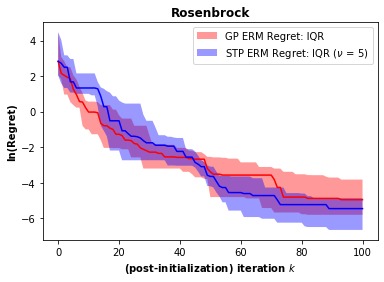

In [179]:
### 10. Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'Red')
plt.plot(median_stp, color = 'Blue')

xstar = np.arange(0, 101, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
